<a href="https://colab.research.google.com/github/crux82/ganbert-pytorch/blob/main/GANBERT_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN-BERT (in Pytorch and compatible with HuggingFace)

This is a Pytorch (+ **Huggingface** transformers) implementation of the GAN-BERT model from https://github.com/crux82/ganbert. While the original GAN-BERT was an extension of BERT, this implementation can be adapted to several architectures, ranging from Roberta to Albert!

**NOTE**: given that this implementation is different from the original one in Tensorflow, some results can be slighty different.


Let's GO!

Required Imports.

In [1]:
#!pip install transformers==4.3.2
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install sentencepiece

##Set random values
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [2]:
from sentence_transformers import SentenceTransformer
from matplotlib import pyplot as plt

In [3]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


### Input Parameters


In [18]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 64
batch_size = 64

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-6
learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 10000
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

#model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "roberta-base"
#model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
#model_name = "amazon/bort"
#model_name = "all-MiniLM-L6-v2"
model_name = "all-mpnet-base-v2"
#model_name = 'sentence-transformers/bert-base-nli-mean-tokens'
#model_name = 'sentence-transformers/paraphrase-MiniLM-L6-v2'
#model_name = "stsb-bert-base"


#--------------------------------
#  Retrieve the TREC QC Dataset
#--------------------------------
#! git clone https://github.com/crux82/ganbert

#  NOTE: in this setting 50 classes are involved
labeled_file = "./ganbert/data/labeled.tsv"
unlabeled_file = "./ganbert/data/unlabeled.tsv"
test_filename = "./ganbert/data/test.tsv"

label_list = ["UNK_UNK","ABBR_abb", "ABBR_exp", "DESC_def", "DESC_desc", 
              "DESC_manner", "DESC_reason", "ENTY_animal", "ENTY_body", 
              "ENTY_color", "ENTY_cremat", "ENTY_currency", "ENTY_dismed", 
              "ENTY_event", "ENTY_food", "ENTY_instru", "ENTY_lang", 
              "ENTY_letter", "ENTY_other", "ENTY_plant", "ENTY_product", 
              "ENTY_religion", "ENTY_sport", "ENTY_substance", "ENTY_symbol", 
              "ENTY_techmeth", "ENTY_termeq", "ENTY_veh", "ENTY_word", "HUM_desc", 
              "HUM_gr", "HUM_ind", "HUM_title", "LOC_city", "LOC_country", 
              "LOC_mount", "LOC_other", "LOC_state", "NUM_code", "NUM_count", 
              "NUM_date", "NUM_dist", "NUM_money", "NUM_ord", "NUM_other", 
              "NUM_perc", "NUM_period", "NUM_speed", "NUM_temp", "NUM_volsize", 
              "NUM_weight"]

Load the Tranformer Model

In [5]:
# transformer = AutoModel.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)
model_transformer = SentenceTransformer(model_name)

loading configuration file /Users/harrison.cook/.cache/torch/sentence_transformers/sentence-transformers_all-mpnet-base-v2/config.json
Model config MPNetConfig {
  "_name_or_path": "/Users/harrison.cook/.cache/torch/sentence_transformers/sentence-transformers_all-mpnet-base-v2/",
  "architectures": [
    "MPNetForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "mpnet",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.18.0",
  "vocab_size": 30527
}

loading weights file /Users/harrison.cook/.cache/torch/sentence_transformers/sentence-transformers_all-mpnet-base-v2/pytorch_model.bin
All model checkpoint weights were used when initializing

Function required to load the dataset

In [6]:
def get_qc_examples(input_file):
  """Creates examples for the training and dev sets."""
  examples = []

  with open(input_file, 'r') as f:
      contents = f.read()
      file_as_list = contents.splitlines()
      for line in file_as_list[1:]:
          split = line.split(" ")
          question = ' '.join(split[1:])

          text_a = question
          inn_split = split[0].split(":")
          label = inn_split[0] + "_" + inn_split[1]
          examples.append((text_a, label))
      f.close()

  return examples

**Load** the input QC dataset (fine-grained)

In [7]:
#Load the examples
labeled_examples = get_qc_examples(labeled_file)
unlabeled_examples = get_qc_examples(unlabeled_file)
test_examples = get_qc_examples(test_filename)

Functions required to convert examples into Dataloader

In [8]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples): 
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label_mask) in examples:
    encoded_sent = model_transformer.encode(text[0])
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)
  
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Convert the input examples into DataLoader

In [9]:
label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)
#If unlabel examples are available
# if unlabeled_examples:
#   train_examples = train_examples + unlabeled_examples
#   #The unlabeled (train) dataset is assigned with a mask set to False
#   tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
#   train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

/var/folders/11/86f3z1k93pq0q7qb52tszh980000gn/T/ipykernel_12749/454584618.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  input_ids = torch.tensor(input_ids)
/var/folders/11/86f3z1k93pq0q7qb52tszh980000gn/T/ipykernel_12749/454584618.py:49: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  label_mask_array = torch.tensor(label_mask_array)


We define the Generator and Discriminator as discussed in https://www.aclweb.org/anthology/2020.acl-main.191/

In [10]:
#------------------------------
#   The Generator as in 
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
        super(Generator, self).__init__()
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

We instantiate the Discriminator and Generator

In [15]:
# The config file is required to get the dimension of the vector produced by 
# the underlying transformer
#config = AutoConfig.from_pretrained(model_name)
#hidden_size = int(config.hidden_size)
hidden_size = 768
# Define the number and width of hidden layers
hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():    
  generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

# print(config)

Let's go with the training procedure

In [19]:
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
#transformer_vars = [i for i in transformer.parameters()]
#d_vars = transformer_vars + [v for v in discriminator.parameters()]
d_vars = [v for v in discriminator.parameters()]
#g_vars = [v for v in generator.parameters()]

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
#gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
#   scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
#                                            num_warmup_steps = num_warmup_steps)

accuracy_array=[]

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    #tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    #transformer.train() 
    #generator.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        #if step % print_each_n_step == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)

        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_label_mask = batch[2].to(device)

        real_batch_size = b_input_ids.shape[0]
     
        # Encode real data in the Transformer
        #model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        #hidden_states = model_outputs[-1]
        hidden_states = b_input_ids
        
        # Generate fake data that should have the same distribution of the ones
        # encoded by the transformer. 
        # First noisy input are used in input to the Generator
        #noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
        # Gnerate Fake data
        #gen_rep = generator(noise)

        # Generate the output of the Discriminator for real and fake data.
        # First, we put together the output of the tranformer and the generator
        disciminator_input = hidden_states
        # Then, we select the output of the disciminator
        features, logits, probs = discriminator(disciminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        # data
        features_list = torch.split(features, real_batch_size)
        D_real_features = features_list[0]
        #D_fake_features = features_list[1]
      
        logits_list = torch.split(logits, real_batch_size)
        D_real_logits = logits_list[0]
        #D_fake_logits = logits_list[1]
        
        probs_list = torch.split(probs, real_batch_size)
        D_real_probs = probs_list[0]
        #D_fake_probs = probs_list[1]

        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        #g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
        #g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
        #g_loss = g_loss_d + g_feat_reg
  
        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples, 
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
          D_L_Supervised = 0
        else:
          D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
                 
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        #D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U #+ D_L_unsupervised2U

        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        # Avoid gradient accumulation
        #gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        #g_loss.backward(retain_graph=True)
        d_loss.backward() 
        
        # Apply modifications
        #gen_optimizer.step()
        dis_optimizer.step()

        # A detail log of the individual losses
        #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
        #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
        #             g_loss_d, g_feat_reg))

        # Save the losses to print them later
        #tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()

        # Update the learning rate with the scheduler
        if apply_scheduler:
          scheduler_d.step()
          #scheduler_g.step()

    # Calculate the average loss over all of the batches.
    #avg_train_loss_g = tr_g_loss / len(train_dataloader)
    avg_train_loss_d = tr_d_loss / len(train_dataloader)             
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    #print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    #transformer.eval() #maybe redundant
    discriminator.eval()
    #generator.eval()

    # Tracking variables 
    total_test_accuracy = 0
   
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        #b_input_mask = batch[1].to(device)
        b_labels = batch[1].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            #model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            #hidden_states = model_outputs[-1]
            hidden_states=b_input_ids
            _, logits, probs = discriminator(hidden_states)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_labels)
            
        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            #'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )
    
    accuracy_array.append(test_accuracy)


======== Epoch 1 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.329
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.562
  Test took: 0:00:00

======== Epoch 2 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.324
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.562
  Test took: 0:00:00

======== Epoch 3 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.332
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.562
  Test took: 0:00:00

======== Epoch 4 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.  

  Accuracy: 0.322
  Test Loss: 3.549
  Test took: 0:00:00

======== Epoch 32 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.316
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.548
  Test took: 0:00:00

======== Epoch 33 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.315
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.548
  Test took: 0:00:00

======== Epoch 34 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.317
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.547
  Test took: 0:00:00

======== Epoch 35 / 10000 ========
Training...
  Batch     

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.283
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.535
  Test took: 0:00:00

======== Epoch 63 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.294
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.534
  Test took: 0:00:00

======== Epoch 64 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.290
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.534
  Test took: 0:00:00

======== Epoch 65 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.292
  Training epcoh took: 0:

  Accuracy: 0.322
  Test Loss: 3.520
  Test took: 0:00:00

======== Epoch 95 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.266
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.519
  Test took: 0:00:00

======== Epoch 96 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.270
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.519
  Test took: 0:00:00

======== Epoch 97 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.255
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.519
  Test took: 0:00:00

======== Epoch 98 / 10000 ========
Training...
  Batch     

  Accuracy: 0.322
  Test Loss: 3.505
  Test took: 0:00:00

======== Epoch 128 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.243
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.504
  Test took: 0:00:00

======== Epoch 129 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.243
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.504
  Test took: 0:00:00

======== Epoch 130 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.228
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.503
  Test took: 0:00:00

======== Epoch 131 / 10000 ========
Training...
  Batch 

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.203
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.490
  Test took: 0:00:00

======== Epoch 160 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.215
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.489
  Test took: 0:00:00

======== Epoch 161 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.213
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.489
  Test took: 0:00:00

======== Epoch 162 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.224
  Training epcoh took:

  Accuracy: 0.322
  Test Loss: 3.475
  Test took: 0:00:00

======== Epoch 192 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.194
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.475
  Test took: 0:00:00

======== Epoch 193 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.177
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.474
  Test took: 0:00:00

======== Epoch 194 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.184
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.474
  Test took: 0:00:00

======== Epoch 195 / 10000 ========
Training...
  Batch 

  Accuracy: 0.322
  Test Loss: 3.461
  Test took: 0:00:00

======== Epoch 223 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.170
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.461
  Test took: 0:00:00

======== Epoch 224 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.175
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.460
  Test took: 0:00:00

======== Epoch 225 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.164
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.460
  Test took: 0:00:00

======== Epoch 226 / 10000 ========
Training...
  Batch 


  Average training loss discriminator: 3.131
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.446
  Test took: 0:00:00

======== Epoch 256 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.145
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.446
  Test took: 0:00:00

======== Epoch 257 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.144
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.445
  Test took: 0:00:00

======== Epoch 258 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.140
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  T


  Average training loss discriminator: 3.089
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.432
  Test took: 0:00:00

======== Epoch 288 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.103
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.432
  Test took: 0:00:00

======== Epoch 289 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.099
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.431
  Test took: 0:00:00

======== Epoch 290 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.115
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  T

  Accuracy: 0.322
  Test Loss: 3.418
  Test took: 0:00:00

======== Epoch 320 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.080
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.418
  Test took: 0:00:00

======== Epoch 321 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.073
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.417
  Test took: 0:00:00

======== Epoch 322 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.075
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.417
  Test took: 0:00:00

======== Epoch 323 / 10000 ========
Training...
  Batch 


  Average training loss discriminator: 3.064
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.404
  Test took: 0:00:00

======== Epoch 351 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.069
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.404
  Test took: 0:00:00

======== Epoch 352 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.059
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.404
  Test took: 0:00:00

======== Epoch 353 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.049
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  T

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.049
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.391
  Test took: 0:00:00

======== Epoch 382 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.038
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.391
  Test took: 0:00:00

======== Epoch 383 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.044
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.390
  Test took: 0:00:00

======== Epoch 384 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.040
  Training epcoh took:

  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.006
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.378
  Test took: 0:00:00

======== Epoch 414 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.015
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.377
  Test took: 0:00:00

======== Epoch 415 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.007
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.377
  Test took: 0:00:00

======== Epoch 416 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training l

  Accuracy: 0.322
  Test Loss: 3.366
  Test took: 0:00:00

======== Epoch 444 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.987
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.365
  Test took: 0:00:00

======== Epoch 445 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 3.012
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.365
  Test took: 0:00:00

======== Epoch 446 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.977
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.364
  Test took: 0:00:00

======== Epoch 447 / 10000 ========
Training...
  Batch 

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.950
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.320
  Test Loss: 3.353
  Test took: 0:00:00

======== Epoch 475 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.962
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.320
  Test Loss: 3.353
  Test took: 0:00:00

======== Epoch 476 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.961
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.320
  Test Loss: 3.352
  Test took: 0:00:00

======== Epoch 477 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.950
  Training epcoh took:

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.943
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.320
  Test Loss: 3.341
  Test took: 0:00:00

======== Epoch 506 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.939
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.320
  Test Loss: 3.341
  Test took: 0:00:00

======== Epoch 507 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.948
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.320
  Test Loss: 3.340
  Test took: 0:00:00

======== Epoch 508 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.933
  Training epcoh took:

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.918
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.320
  Test Loss: 3.330
  Test took: 0:00:00

======== Epoch 536 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.903
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.320
  Test Loss: 3.329
  Test took: 0:00:00

======== Epoch 537 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.903
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.320
  Test Loss: 3.329
  Test took: 0:00:00

======== Epoch 538 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.903
  Training epcoh took:

  Accuracy: 0.322
  Test Loss: 3.318
  Test took: 0:00:00

======== Epoch 567 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.902
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.318
  Test took: 0:00:00

======== Epoch 568 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.914
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.317
  Test took: 0:00:00

======== Epoch 569 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.882
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.317
  Test took: 0:00:00

======== Epoch 570 / 10000 ========
Training...
  Batch 

  Accuracy: 0.322
  Test Loss: 3.307
  Test took: 0:00:00

======== Epoch 598 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.870
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.306
  Test took: 0:00:00

======== Epoch 599 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.880
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.306
  Test took: 0:00:00

======== Epoch 600 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.873
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.306
  Test took: 0:00:00

======== Epoch 601 / 10000 ========
Training...
  Batch 

  Accuracy: 0.322
  Test Loss: 3.296
  Test took: 0:00:00

======== Epoch 629 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.858
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.296
  Test took: 0:00:00

======== Epoch 630 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.842
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.295
  Test took: 0:00:00

======== Epoch 631 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.831
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.295
  Test took: 0:00:00

======== Epoch 632 / 10000 ========
Training...
  Batch 

  Accuracy: 0.322
  Test Loss: 3.286
  Test took: 0:00:00

======== Epoch 659 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.810
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.285
  Test took: 0:00:00

======== Epoch 660 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.835
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.285
  Test took: 0:00:00

======== Epoch 661 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.812
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.285
  Test took: 0:00:00

======== Epoch 662 / 10000 ========
Training...
  Batch 

  Accuracy: 0.322
  Test Loss: 3.276
  Test took: 0:00:00

======== Epoch 690 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.776
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.275
  Test took: 0:00:00

======== Epoch 691 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.793
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.275
  Test took: 0:00:00

======== Epoch 692 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.806
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.275
  Test took: 0:00:00

======== Epoch 693 / 10000 ========
Training...
  Batch 

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.789
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.266
  Test took: 0:00:00

======== Epoch 721 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.789
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.266
  Test took: 0:00:00

======== Epoch 722 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.767
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.322
  Test Loss: 3.265
  Test took: 0:00:00

======== Epoch 723 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.768
  Training epcoh took:

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.774
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.324
  Test Loss: 3.257
  Test took: 0:00:00

======== Epoch 752 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.758
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.324
  Test Loss: 3.256
  Test took: 0:00:00

======== Epoch 753 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.780
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.324
  Test Loss: 3.256
  Test took: 0:00:00

======== Epoch 754 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.760
  Training epcoh took:

  Accuracy: 0.326
  Test Loss: 3.248
  Test took: 0:00:00

======== Epoch 783 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.753
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.326
  Test Loss: 3.248
  Test took: 0:00:00

======== Epoch 784 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.729
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.326
  Test Loss: 3.247
  Test took: 0:00:00

======== Epoch 785 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.716
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.326
  Test Loss: 3.247
  Test took: 0:00:00

======== Epoch 786 / 10000 ========
Training...
  Batch 


  Average training loss discriminator: 2.701
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.326
  Test Loss: 3.238
  Test took: 0:00:00

======== Epoch 816 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.699
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.326
  Test Loss: 3.238
  Test took: 0:00:00

======== Epoch 817 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.715
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.326
  Test Loss: 3.238
  Test took: 0:00:00

======== Epoch 818 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.699
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.326
  T

  Accuracy: 0.330
  Test Loss: 3.230
  Test took: 0:00:00

======== Epoch 847 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.688
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.330
  Test Loss: 3.230
  Test took: 0:00:00

======== Epoch 848 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.707
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.330
  Test Loss: 3.229
  Test took: 0:00:00

======== Epoch 849 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.679
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.330
  Test Loss: 3.229
  Test took: 0:00:00

======== Epoch 850 / 10000 ========
Training...
  Batch 

  Accuracy: 0.330
  Test Loss: 3.221
  Test took: 0:00:00

======== Epoch 880 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.674
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.330
  Test Loss: 3.221
  Test took: 0:00:00

======== Epoch 881 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.676
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.330
  Test Loss: 3.221
  Test took: 0:00:00

======== Epoch 882 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.667
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.330
  Test Loss: 3.221
  Test took: 0:00:00

======== Epoch 883 / 10000 ========
Training...
  Batch 

  Accuracy: 0.332
  Test Loss: 3.213
  Test took: 0:00:00

======== Epoch 913 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.658
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.332
  Test Loss: 3.213
  Test took: 0:00:00

======== Epoch 914 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.636
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.332
  Test Loss: 3.212
  Test took: 0:00:00

======== Epoch 915 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.653
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.332
  Test Loss: 3.212
  Test took: 0:00:00

======== Epoch 916 / 10000 ========
Training...
  Batch 


  Average training loss discriminator: 2.647
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.334
  Test Loss: 3.205
  Test took: 0:00:00

======== Epoch 945 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.643
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.334
  Test Loss: 3.205
  Test took: 0:00:00

======== Epoch 946 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.613
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.334
  Test Loss: 3.205
  Test took: 0:00:00

======== Epoch 947 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.620
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.334
  T

  Accuracy: 0.346
  Test Loss: 3.198
  Test took: 0:00:00

======== Epoch 975 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.635
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.346
  Test Loss: 3.198
  Test took: 0:00:00

======== Epoch 976 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.602
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.346
  Test Loss: 3.198
  Test took: 0:00:00

======== Epoch 977 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.599
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.346
  Test Loss: 3.198
  Test took: 0:00:00

======== Epoch 978 / 10000 ========
Training...
  Batch 

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.587
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.346
  Test Loss: 3.192
  Test took: 0:00:00

======== Epoch 1005 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.571
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.346
  Test Loss: 3.191
  Test took: 0:00:00

======== Epoch 1006 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.590
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.346
  Test Loss: 3.191
  Test took: 0:00:00

======== Epoch 1007 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.596
  Training epcoh to

  Accuracy: 0.346
  Test Loss: 3.185
  Test took: 0:00:00

======== Epoch 1036 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.568
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.346
  Test Loss: 3.185
  Test took: 0:00:00

======== Epoch 1037 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.578
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.346
  Test Loss: 3.185
  Test took: 0:00:00

======== Epoch 1038 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.537
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.346
  Test Loss: 3.184
  Test took: 0:00:00

======== Epoch 1039 / 10000 ========
Training...
  Ba

  Accuracy: 0.348
  Test Loss: 3.178
  Test took: 0:00:00

======== Epoch 1069 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.550
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.348
  Test Loss: 3.178
  Test took: 0:00:00

======== Epoch 1070 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.544
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.348
  Test Loss: 3.178
  Test took: 0:00:00

======== Epoch 1071 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.523
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.348
  Test Loss: 3.177
  Test took: 0:00:00

======== Epoch 1072 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 2.524
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.348
  Test Loss: 3.172
  Test took: 0:00:00

======== Epoch 1097 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.551
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.348
  Test Loss: 3.172
  Test took: 0:00:00

======== Epoch 1098 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.531
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.348
  Test Loss: 3.172
  Test took: 0:00:00

======== Epoch 1099 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.540
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.348


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.520
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.348
  Test Loss: 3.166
  Test took: 0:00:00

======== Epoch 1130 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.503
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.348
  Test Loss: 3.166
  Test took: 0:00:00

======== Epoch 1131 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.520
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.348
  Test Loss: 3.166
  Test took: 0:00:00

======== Epoch 1132 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.515
  Training epcoh to


  Average training loss discriminator: 2.487
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.352
  Test Loss: 3.160
  Test took: 0:00:00

======== Epoch 1162 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.495
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.352
  Test Loss: 3.159
  Test took: 0:00:00

======== Epoch 1163 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.506
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.352
  Test Loss: 3.159
  Test took: 0:00:00

======== Epoch 1164 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.463
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.352



  Average training loss discriminator: 2.499
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.354
  Test Loss: 3.153
  Test took: 0:00:00

======== Epoch 1195 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.470
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.354
  Test Loss: 3.153
  Test took: 0:00:00

======== Epoch 1196 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.481
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.354
  Test Loss: 3.153
  Test took: 0:00:00

======== Epoch 1197 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.480
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.354


  Accuracy: 0.360
  Test Loss: 3.148
  Test took: 0:00:00

======== Epoch 1227 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.442
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.360
  Test Loss: 3.147
  Test took: 0:00:00

======== Epoch 1228 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.464
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.360
  Test Loss: 3.147
  Test took: 0:00:00

======== Epoch 1229 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.468
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.360
  Test Loss: 3.147
  Test took: 0:00:00

======== Epoch 1230 / 10000 ========
Training...
  Ba

  Accuracy: 0.362
  Test Loss: 3.142
  Test took: 0:00:00

======== Epoch 1259 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.425
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.362
  Test Loss: 3.142
  Test took: 0:00:00

======== Epoch 1260 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.444
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.362
  Test Loss: 3.142
  Test took: 0:00:00

======== Epoch 1261 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.461
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.362
  Test Loss: 3.142
  Test took: 0:00:00

======== Epoch 1262 / 10000 ========
Training...
  Ba

  Accuracy: 0.362
  Test Loss: 3.137
  Test took: 0:00:00

======== Epoch 1290 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.427
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.362
  Test Loss: 3.137
  Test took: 0:00:00

======== Epoch 1291 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.431
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.362
  Test Loss: 3.136
  Test took: 0:00:00

======== Epoch 1292 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.422
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.362
  Test Loss: 3.136
  Test took: 0:00:00

======== Epoch 1293 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 2.411
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.362
  Test Loss: 3.131
  Test took: 0:00:00

======== Epoch 1321 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.404
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.362
  Test Loss: 3.131
  Test took: 0:00:00

======== Epoch 1322 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.395
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.362
  Test Loss: 3.131
  Test took: 0:00:00

======== Epoch 1323 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.399
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.362


  Accuracy: 0.364
  Test Loss: 3.126
  Test took: 0:00:00

======== Epoch 1350 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.395
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.364
  Test Loss: 3.126
  Test took: 0:00:00

======== Epoch 1351 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.392
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.364
  Test Loss: 3.126
  Test took: 0:00:00

======== Epoch 1352 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.407
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.364
  Test Loss: 3.126
  Test took: 0:00:00

======== Epoch 1353 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 2.372
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.372
  Test Loss: 3.121
  Test took: 0:00:00

======== Epoch 1381 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.368
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.372
  Test Loss: 3.121
  Test took: 0:00:00

======== Epoch 1382 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.385
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.372
  Test Loss: 3.121
  Test took: 0:00:00

======== Epoch 1383 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.380
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.372


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.349
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.376
  Test Loss: 3.116
  Test took: 0:00:00

======== Epoch 1414 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.335
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.376
  Test Loss: 3.116
  Test took: 0:00:00

======== Epoch 1415 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.394
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.376
  Test Loss: 3.116
  Test took: 0:00:00

======== Epoch 1416 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.373
  Training epcoh to


  Average training loss discriminator: 2.332
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.380
  Test Loss: 3.111
  Test took: 0:00:00

======== Epoch 1446 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.323
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.380
  Test Loss: 3.111
  Test took: 0:00:00

======== Epoch 1447 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.325
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.380
  Test Loss: 3.111
  Test took: 0:00:00

======== Epoch 1448 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.347
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.380



  Average training loss discriminator: 2.324
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.386
  Test Loss: 3.106
  Test took: 0:00:00

======== Epoch 1478 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.326
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.386
  Test Loss: 3.105
  Test took: 0:00:00

======== Epoch 1479 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.305
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.386
  Test Loss: 3.105
  Test took: 0:00:00

======== Epoch 1480 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.332
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.386



  Average training loss discriminator: 2.298
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.386
  Test Loss: 3.101
  Test took: 0:00:00

======== Epoch 1509 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.326
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.386
  Test Loss: 3.101
  Test took: 0:00:00

======== Epoch 1510 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.289
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.386
  Test Loss: 3.101
  Test took: 0:00:00

======== Epoch 1511 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.297
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.386


  Accuracy: 0.390
  Test Loss: 3.096
  Test took: 0:00:00

======== Epoch 1541 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.263
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.390
  Test Loss: 3.096
  Test took: 0:00:00

======== Epoch 1542 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.280
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.390
  Test Loss: 3.096
  Test took: 0:00:00

======== Epoch 1543 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.308
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.390
  Test Loss: 3.096
  Test took: 0:00:00

======== Epoch 1544 / 10000 ========
Training...
  Ba

  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.242
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.390
  Test Loss: 3.091
  Test took: 0:00:00

======== Epoch 1573 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.281
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.390
  Test Loss: 3.091
  Test took: 0:00:00

======== Epoch 1574 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.290
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.390
  Test Loss: 3.091
  Test took: 0:00:00

======== Epoch 1575 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average trainin

  Accuracy: 0.394
  Test Loss: 3.087
  Test took: 0:00:00

======== Epoch 1604 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.242
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.394
  Test Loss: 3.086
  Test took: 0:00:00

======== Epoch 1605 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.271
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.394
  Test Loss: 3.086
  Test took: 0:00:00

======== Epoch 1606 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.226
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.394
  Test Loss: 3.086
  Test took: 0:00:00

======== Epoch 1607 / 10000 ========
Training...
  Ba

  Accuracy: 0.402
  Test Loss: 3.082
  Test took: 0:00:00

======== Epoch 1632 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.262
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.404
  Test Loss: 3.082
  Test took: 0:00:00

======== Epoch 1633 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.215
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.404
  Test Loss: 3.082
  Test took: 0:00:00

======== Epoch 1634 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.248
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.404
  Test Loss: 3.082
  Test took: 0:00:00

======== Epoch 1635 / 10000 ========
Training...
  Ba

  Accuracy: 0.408
  Test Loss: 3.078
  Test took: 0:00:00

======== Epoch 1664 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.209
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410
  Test Loss: 3.077
  Test took: 0:00:00

======== Epoch 1665 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.236
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410
  Test Loss: 3.077
  Test took: 0:00:00

======== Epoch 1666 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.220
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410
  Test Loss: 3.077
  Test took: 0:00:00

======== Epoch 1667 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 2.207
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410
  Test Loss: 3.073
  Test took: 0:00:00

======== Epoch 1695 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.196
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410
  Test Loss: 3.073
  Test took: 0:00:00

======== Epoch 1696 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.231
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410
  Test Loss: 3.073
  Test took: 0:00:00

======== Epoch 1697 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.232
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.410



  Average training loss discriminator: 2.192
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.420
  Test Loss: 3.069
  Test took: 0:00:00

======== Epoch 1725 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.218
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.420
  Test Loss: 3.068
  Test took: 0:00:00

======== Epoch 1726 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.207
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.420
  Test Loss: 3.068
  Test took: 0:00:00

======== Epoch 1727 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.155
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.420


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.185
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.424
  Test Loss: 3.064
  Test took: 0:00:00

======== Epoch 1758 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.182
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.424
  Test Loss: 3.064
  Test took: 0:00:00

======== Epoch 1759 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.162
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.424
  Test Loss: 3.063
  Test took: 0:00:00

======== Epoch 1760 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.195
  Training epcoh to

  Accuracy: 0.424
  Test Loss: 3.059
  Test took: 0:00:00

======== Epoch 1790 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.170
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.424
  Test Loss: 3.059
  Test took: 0:00:00

======== Epoch 1791 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.185
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.424
  Test Loss: 3.059
  Test took: 0:00:00

======== Epoch 1792 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.183
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.424
  Test Loss: 3.058
  Test took: 0:00:00

======== Epoch 1793 / 10000 ========
Training...
  Ba

  Accuracy: 0.426
  Test Loss: 3.054
  Test took: 0:00:00

======== Epoch 1821 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.162
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.426
  Test Loss: 3.054
  Test took: 0:00:00

======== Epoch 1822 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.149
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.426
  Test Loss: 3.054
  Test took: 0:00:00

======== Epoch 1823 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.149
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.426
  Test Loss: 3.053
  Test took: 0:00:00

======== Epoch 1824 / 10000 ========
Training...
  Ba

  Accuracy: 0.426
  Test Loss: 3.049
  Test took: 0:00:00

======== Epoch 1853 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.118
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.426
  Test Loss: 3.049
  Test took: 0:00:00

======== Epoch 1854 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.111
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.426
  Test Loss: 3.049
  Test took: 0:00:00

======== Epoch 1855 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.129
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.426
  Test Loss: 3.049
  Test took: 0:00:00

======== Epoch 1856 / 10000 ========
Training...
  Ba

  Accuracy: 0.428
  Test Loss: 3.044
  Test took: 0:00:00

======== Epoch 1885 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.151
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.428
  Test Loss: 3.044
  Test took: 0:00:00

======== Epoch 1886 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.104
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.428
  Test Loss: 3.044
  Test took: 0:00:00

======== Epoch 1887 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.133
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.428
  Test Loss: 3.044
  Test took: 0:00:00

======== Epoch 1888 / 10000 ========
Training...
  Ba

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.076
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.430
  Test Loss: 3.039
  Test took: 0:00:00

======== Epoch 1918 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.106
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.430
  Test Loss: 3.039
  Test took: 0:00:00

======== Epoch 1919 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.106
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.430
  Test Loss: 3.039
  Test took: 0:00:00

======== Epoch 1920 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.109
  Training epcoh to

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.112
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.434
  Test Loss: 3.035
  Test took: 0:00:00

======== Epoch 1948 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.086
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.434
  Test Loss: 3.035
  Test took: 0:00:00

======== Epoch 1949 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.084
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.434
  Test Loss: 3.035
  Test took: 0:00:00

======== Epoch 1950 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.084
  Training epcoh to

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.112
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.436
  Test Loss: 3.030
  Test took: 0:00:00

======== Epoch 1978 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.092
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.436
  Test Loss: 3.030
  Test took: 0:00:00

======== Epoch 1979 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.069
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.436
  Test Loss: 3.030
  Test took: 0:00:00

======== Epoch 1980 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.106
  Training epcoh to

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.064
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.438
  Test Loss: 3.026
  Test took: 0:00:00

======== Epoch 2008 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.031
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.438
  Test Loss: 3.026
  Test took: 0:00:00

======== Epoch 2009 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.085
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.438
  Test Loss: 3.026
  Test took: 0:00:00

======== Epoch 2010 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.060
  Training epcoh to


  Average training loss discriminator: 2.043
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.440
  Test Loss: 3.022
  Test took: 0:00:00

======== Epoch 2036 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.012
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.440
  Test Loss: 3.022
  Test took: 0:00:00

======== Epoch 2037 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.008
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.440
  Test Loss: 3.022
  Test took: 0:00:00

======== Epoch 2038 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.077
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.440


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.044
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.442
  Test Loss: 3.018
  Test took: 0:00:00

======== Epoch 2068 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.051
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.442
  Test Loss: 3.017
  Test took: 0:00:00

======== Epoch 2069 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.019
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.442
  Test Loss: 3.017
  Test took: 0:00:00

======== Epoch 2070 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.048
  Training epcoh to


  Average training loss discriminator: 2.013
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.442
  Test Loss: 3.013
  Test took: 0:00:00

======== Epoch 2099 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.047
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.442
  Test Loss: 3.013
  Test took: 0:00:00

======== Epoch 2100 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.036
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.442
  Test Loss: 3.013
  Test took: 0:00:00

======== Epoch 2101 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.977
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.442


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.989
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 3.009
  Test took: 0:00:00

======== Epoch 2131 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.002
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 3.009
  Test took: 0:00:00

======== Epoch 2132 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.999
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 3.008
  Test took: 0:00:00

======== Epoch 2133 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 2.007
  Training epcoh to


  Average training loss discriminator: 1.996
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 3.005
  Test took: 0:00:00

======== Epoch 2160 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.973
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 3.004
  Test took: 0:00:00

======== Epoch 2161 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.997
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 3.004
  Test took: 0:00:00

======== Epoch 2162 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.987
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444



  Average training loss discriminator: 1.968
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 3.000
  Test took: 0:00:00

======== Epoch 2193 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.959
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 3.000
  Test took: 0:00:00

======== Epoch 2194 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.975
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 3.000
  Test took: 0:00:00

======== Epoch 2195 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.957
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444


  Accuracy: 0.444
  Test Loss: 2.995
  Test took: 0:00:00

======== Epoch 2225 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.972
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.995
  Test took: 0:00:00

======== Epoch 2226 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.931
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.995
  Test took: 0:00:00

======== Epoch 2227 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.958
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.995
  Test took: 0:00:00

======== Epoch 2228 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 1.953
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.991
  Test took: 0:00:00

======== Epoch 2253 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.931
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.991
  Test took: 0:00:00

======== Epoch 2254 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.963
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.991
  Test took: 0:00:00

======== Epoch 2255 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.939
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444



  Average training loss discriminator: 1.919
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.986
  Test took: 0:00:00

======== Epoch 2286 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.939
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.986
  Test took: 0:00:00

======== Epoch 2287 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.899
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.986
  Test took: 0:00:00

======== Epoch 2288 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.939
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444



  Average training loss discriminator: 1.905
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.982
  Test took: 0:00:00

======== Epoch 2314 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.906
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.982
  Test took: 0:00:00

======== Epoch 2315 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.912
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.982
  Test took: 0:00:00

======== Epoch 2316 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.880
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444



  Average training loss discriminator: 1.886
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.978
  Test took: 0:00:00

======== Epoch 2347 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.916
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.978
  Test took: 0:00:00

======== Epoch 2348 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.881
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.977
  Test took: 0:00:00

======== Epoch 2349 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.907
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444


  Accuracy: 0.444
  Test Loss: 2.973
  Test took: 0:00:00

======== Epoch 2379 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.867
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.973
  Test took: 0:00:00

======== Epoch 2380 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.907
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.973
  Test took: 0:00:00

======== Epoch 2381 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.884
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.973
  Test took: 0:00:00

======== Epoch 2382 / 10000 ========
Training...
  Ba

  Accuracy: 0.444
  Test Loss: 2.969
  Test took: 0:00:00

======== Epoch 2407 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.889
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.969
  Test took: 0:00:00

======== Epoch 2408 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.868
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.969
  Test took: 0:00:00

======== Epoch 2409 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.854
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.969
  Test took: 0:00:00

======== Epoch 2410 / 10000 ========
Training...
  Ba

  Accuracy: 0.444
  Test Loss: 2.965
  Test took: 0:00:00

======== Epoch 2435 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.846
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.965
  Test took: 0:00:00

======== Epoch 2436 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.841
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.965
  Test took: 0:00:00

======== Epoch 2437 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.831
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.965
  Test took: 0:00:00

======== Epoch 2438 / 10000 ========
Training...
  Ba

  Accuracy: 0.444
  Test Loss: 2.961
  Test took: 0:00:00

======== Epoch 2468 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.848
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.961
  Test took: 0:00:00

======== Epoch 2469 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.846
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.960
  Test took: 0:00:00

======== Epoch 2470 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.851
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.960
  Test took: 0:00:00

======== Epoch 2471 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 1.848
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.957
  Test took: 0:00:00

======== Epoch 2496 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.804
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.957
  Test took: 0:00:00

======== Epoch 2497 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.847
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.957
  Test took: 0:00:00

======== Epoch 2498 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.801
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446


  Accuracy: 0.444
  Test Loss: 2.952
  Test took: 0:00:00

======== Epoch 2529 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.815
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.952
  Test took: 0:00:00

======== Epoch 2530 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.836
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.952
  Test took: 0:00:00

======== Epoch 2531 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.807
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.952
  Test took: 0:00:00

======== Epoch 2532 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 1.797
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.948
  Test took: 0:00:00

======== Epoch 2557 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.798
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.948
  Test took: 0:00:00

======== Epoch 2558 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.815
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444
  Test Loss: 2.948
  Test took: 0:00:00

======== Epoch 2559 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.813
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.444



  Average training loss discriminator: 1.812
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.944
  Test took: 0:00:00

======== Epoch 2590 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.807
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.944
  Test took: 0:00:00

======== Epoch 2591 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.806
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.944
  Test took: 0:00:00

======== Epoch 2592 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.799
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446



  Average training loss discriminator: 1.785
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.939
  Test took: 0:00:00

======== Epoch 2623 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.753
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.939
  Test took: 0:00:00

======== Epoch 2624 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.759
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.939
  Test took: 0:00:00

======== Epoch 2625 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.774
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.733
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.935
  Test took: 0:00:00

======== Epoch 2656 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.756
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.935
  Test took: 0:00:00

======== Epoch 2657 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.746
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.935
  Test took: 0:00:00

======== Epoch 2658 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.721
  Training epcoh to

  Accuracy: 0.446
  Test Loss: 2.931
  Test took: 0:00:00

======== Epoch 2688 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.752
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.931
  Test took: 0:00:00

======== Epoch 2689 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.732
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.931
  Test took: 0:00:00

======== Epoch 2690 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.769
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.930
  Test took: 0:00:00

======== Epoch 2691 / 10000 ========
Training...
  Ba

  Accuracy: 0.446
  Test Loss: 2.927
  Test took: 0:00:00

======== Epoch 2716 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.726
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.927
  Test took: 0:00:00

======== Epoch 2717 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.732
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.927
  Test took: 0:00:00

======== Epoch 2718 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.735
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.927
  Test took: 0:00:00

======== Epoch 2719 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 1.713
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.923
  Test took: 0:00:00

======== Epoch 2744 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.701
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.923
  Test took: 0:00:00

======== Epoch 2745 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.684
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.923
  Test took: 0:00:00

======== Epoch 2746 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.699
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446



  Average training loss discriminator: 1.708
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.919
  Test took: 0:00:00

======== Epoch 2777 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.710
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.919
  Test took: 0:00:00

======== Epoch 2778 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.695
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.919
  Test took: 0:00:00

======== Epoch 2779 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.696
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446


  Accuracy: 0.446
  Test Loss: 2.915
  Test took: 0:00:00

======== Epoch 2806 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.692
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.915
  Test took: 0:00:00

======== Epoch 2807 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.687
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.915
  Test took: 0:00:00

======== Epoch 2808 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.702
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.915
  Test took: 0:00:00

======== Epoch 2809 / 10000 ========
Training...
  Ba

  Accuracy: 0.446
  Test Loss: 2.911
  Test took: 0:00:00

======== Epoch 2839 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.696
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.911
  Test took: 0:00:00

======== Epoch 2840 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.649
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.911
  Test took: 0:00:00

======== Epoch 2841 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.648
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.911
  Test took: 0:00:00

======== Epoch 2842 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 1.665
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.908
  Test took: 0:00:00

======== Epoch 2867 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.659
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.908
  Test took: 0:00:00

======== Epoch 2868 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.658
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446
  Test Loss: 2.907
  Test took: 0:00:00

======== Epoch 2869 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.614
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.446



  Average training loss discriminator: 1.633
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.448
  Test Loss: 2.903
  Test took: 0:00:00

======== Epoch 2900 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.628
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.448
  Test Loss: 2.903
  Test took: 0:00:00

======== Epoch 2901 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.604
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.448
  Test Loss: 2.903
  Test took: 0:00:00

======== Epoch 2902 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.623
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.448


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.616
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.448
  Test Loss: 2.899
  Test took: 0:00:00

======== Epoch 2933 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.633
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.448
  Test Loss: 2.899
  Test took: 0:00:00

======== Epoch 2934 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.642
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.448
  Test Loss: 2.899
  Test took: 0:00:00

======== Epoch 2935 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.624
  Training epcoh to

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.603
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.896
  Test took: 0:00:00

======== Epoch 2961 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.644
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.896
  Test took: 0:00:00

======== Epoch 2962 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.596
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.895
  Test took: 0:00:00

======== Epoch 2963 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.671
  Training epcoh to

  Accuracy: 0.450
  Test Loss: 2.892
  Test took: 0:00:00

======== Epoch 2993 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.589
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.891
  Test took: 0:00:00

======== Epoch 2994 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.628
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.891
  Test took: 0:00:00

======== Epoch 2995 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.597
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.891
  Test took: 0:00:00

======== Epoch 2996 / 10000 ========
Training...
  Ba

  Accuracy: 0.450
  Test Loss: 2.888
  Test took: 0:00:00

======== Epoch 3026 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.587
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.888
  Test took: 0:00:00

======== Epoch 3027 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.562
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.887
  Test took: 0:00:00

======== Epoch 3028 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.596
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.887
  Test took: 0:00:00

======== Epoch 3029 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 1.611
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.884
  Test took: 0:00:00

======== Epoch 3054 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.578
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.884
  Test took: 0:00:00

======== Epoch 3055 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.554
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.884
  Test took: 0:00:00

======== Epoch 3056 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.574
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450


  Accuracy: 0.450
  Test Loss: 2.880
  Test took: 0:00:00

======== Epoch 3086 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.569
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.880
  Test took: 0:00:00

======== Epoch 3087 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.605
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.880
  Test took: 0:00:00

======== Epoch 3088 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.562
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.880
  Test took: 0:00:00

======== Epoch 3089 / 10000 ========
Training...
  Ba

  Accuracy: 0.450
  Test Loss: 2.877
  Test took: 0:00:00

======== Epoch 3119 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.556
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.876
  Test took: 0:00:00

======== Epoch 3120 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.554
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.876
  Test took: 0:00:00

======== Epoch 3121 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.531
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.876
  Test took: 0:00:00

======== Epoch 3122 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 1.562
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.873
  Test took: 0:00:00

======== Epoch 3147 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.533
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.873
  Test took: 0:00:00

======== Epoch 3148 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.557
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.873
  Test took: 0:00:00

======== Epoch 3149 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.567
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450



  Average training loss discriminator: 1.514
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.870
  Test took: 0:00:00

======== Epoch 3180 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.519
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.870
  Test took: 0:00:00

======== Epoch 3181 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.511
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.869
  Test took: 0:00:00

======== Epoch 3182 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.540
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450



  Average training loss discriminator: 1.511
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.866
  Test took: 0:00:00

======== Epoch 3213 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.547
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.866
  Test took: 0:00:00

======== Epoch 3214 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.526
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.866
  Test took: 0:00:00

======== Epoch 3215 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.489
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.526
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.862
  Test took: 0:00:00

======== Epoch 3246 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.485
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.862
  Test took: 0:00:00

======== Epoch 3247 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.519
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.862
  Test took: 0:00:00

======== Epoch 3248 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.476
  Training epcoh to


  Average training loss discriminator: 1.470
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.448
  Test Loss: 2.858
  Test took: 0:00:00

======== Epoch 3279 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.480
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.448
  Test Loss: 2.858
  Test took: 0:00:00

======== Epoch 3280 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.458
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.448
  Test Loss: 2.858
  Test took: 0:00:00

======== Epoch 3281 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.437
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.448


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.476
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.448
  Test Loss: 2.855
  Test took: 0:00:00

======== Epoch 3307 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.481
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.448
  Test Loss: 2.855
  Test took: 0:00:00

======== Epoch 3308 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.454
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.448
  Test Loss: 2.855
  Test took: 0:00:00

======== Epoch 3309 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.462
  Training epcoh to

  Accuracy: 0.450
  Test Loss: 2.852
  Test took: 0:00:00

======== Epoch 3336 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.450
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.852
  Test took: 0:00:00

======== Epoch 3337 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.419
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.852
  Test took: 0:00:00

======== Epoch 3338 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.452
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.450
  Test Loss: 2.852
  Test took: 0:00:00

======== Epoch 3339 / 10000 ========
Training...
  Ba

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.426
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.452
  Test Loss: 2.848
  Test took: 0:00:00

======== Epoch 3368 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.423
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.452
  Test Loss: 2.848
  Test took: 0:00:00

======== Epoch 3369 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.454
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.452
  Test Loss: 2.848
  Test took: 0:00:00

======== Epoch 3370 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.417
  Training epcoh to

  Accuracy: 0.454
  Test Loss: 2.845
  Test took: 0:00:00

======== Epoch 3400 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.448
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.454
  Test Loss: 2.845
  Test took: 0:00:00

======== Epoch 3401 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.425
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.454
  Test Loss: 2.845
  Test took: 0:00:00

======== Epoch 3402 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.427
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.454
  Test Loss: 2.845
  Test took: 0:00:00

======== Epoch 3403 / 10000 ========
Training...
  Ba

  Accuracy: 0.454
  Test Loss: 2.841
  Test took: 0:00:00

======== Epoch 3432 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.400
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.841
  Test took: 0:00:00

======== Epoch 3433 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.421
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.841
  Test took: 0:00:00

======== Epoch 3434 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.389
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.841
  Test took: 0:00:00

======== Epoch 3435 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 1.369
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.838
  Test took: 0:00:00

======== Epoch 3464 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.403
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.838
  Test took: 0:00:00

======== Epoch 3465 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.425
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.838
  Test took: 0:00:00

======== Epoch 3466 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.425
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456


  Accuracy: 0.456
  Test Loss: 2.835
  Test took: 0:00:00

======== Epoch 3496 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.392
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.835
  Test took: 0:00:00

======== Epoch 3497 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.381
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.835
  Test took: 0:00:00

======== Epoch 3498 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.382
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.835
  Test took: 0:00:00

======== Epoch 3499 / 10000 ========
Training...
  Ba

  Accuracy: 0.456
  Test Loss: 2.832
  Test took: 0:00:00

======== Epoch 3527 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.341
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.832
  Test took: 0:00:00

======== Epoch 3528 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.364
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.831
  Test took: 0:00:00

======== Epoch 3529 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.410
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.831
  Test took: 0:00:00

======== Epoch 3530 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 1.341
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.828
  Test took: 0:00:00

======== Epoch 3560 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.363
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.828
  Test took: 0:00:00

======== Epoch 3561 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.367
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.828
  Test took: 0:00:00

======== Epoch 3562 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.394
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456


  Accuracy: 0.454
  Test Loss: 2.825
  Test took: 0:00:00

======== Epoch 3593 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.332
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.454
  Test Loss: 2.825
  Test took: 0:00:00

======== Epoch 3594 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.355
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.454
  Test Loss: 2.824
  Test took: 0:00:00

======== Epoch 3595 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.334
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.454
  Test Loss: 2.824
  Test took: 0:00:00

======== Epoch 3596 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 1.333
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.822
  Test took: 0:00:00

======== Epoch 3621 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.318
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.822
  Test took: 0:00:00

======== Epoch 3622 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.333
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.822
  Test took: 0:00:00

======== Epoch 3623 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.308
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.291
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.819
  Test took: 0:00:00

======== Epoch 3653 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.309
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.819
  Test took: 0:00:00

======== Epoch 3654 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.319
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.819
  Test took: 0:00:00

======== Epoch 3655 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.323
  Training epcoh to


  Average training loss discriminator: 1.294
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.816
  Test took: 0:00:00

======== Epoch 3685 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.304
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.816
  Test took: 0:00:00

======== Epoch 3686 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.277
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456
  Test Loss: 2.815
  Test took: 0:00:00

======== Epoch 3687 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.312
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.456



  Average training loss discriminator: 1.279
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.812
  Test took: 0:00:00

======== Epoch 3718 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.300
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.812
  Test took: 0:00:00

======== Epoch 3719 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.328
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.812
  Test took: 0:00:00

======== Epoch 3720 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.268
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458



  Average training loss discriminator: 1.275
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.810
  Test took: 0:00:00

======== Epoch 3746 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.276
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.810
  Test took: 0:00:00

======== Epoch 3747 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.292
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.810
  Test took: 0:00:00

======== Epoch 3748 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.274
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458


  Accuracy: 0.460
  Test Loss: 2.807
  Test took: 0:00:00

======== Epoch 3774 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.235
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.807
  Test took: 0:00:00

======== Epoch 3775 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.246
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.807
  Test took: 0:00:00

======== Epoch 3776 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.284
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.807
  Test took: 0:00:00

======== Epoch 3777 / 10000 ========
Training...
  Ba

  Accuracy: 0.460
  Test Loss: 2.804
  Test took: 0:00:00

======== Epoch 3802 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.269
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.804
  Test took: 0:00:00

======== Epoch 3803 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.264
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.804
  Test took: 0:00:00

======== Epoch 3804 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.253
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.804
  Test took: 0:00:00

======== Epoch 3805 / 10000 ========
Training...
  Ba

  Accuracy: 0.460
  Test Loss: 2.802
  Test took: 0:00:00

======== Epoch 3830 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.231
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.802
  Test took: 0:00:00

======== Epoch 3831 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.235
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.801
  Test took: 0:00:00

======== Epoch 3832 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.280
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.801
  Test took: 0:00:00

======== Epoch 3833 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 1.245
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.799
  Test took: 0:00:00

======== Epoch 3858 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.226
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.799
  Test took: 0:00:00

======== Epoch 3859 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.224
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.799
  Test took: 0:00:00

======== Epoch 3860 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.225
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460


  Accuracy: 0.460
  Test Loss: 2.797
  Test took: 0:00:00

======== Epoch 3886 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.232
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.797
  Test took: 0:00:00

======== Epoch 3887 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.224
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.797
  Test took: 0:00:00

======== Epoch 3888 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.205
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.796
  Test took: 0:00:00

======== Epoch 3889 / 10000 ========
Training...
  Ba

  Accuracy: 0.460
  Test Loss: 2.794
  Test took: 0:00:00

======== Epoch 3915 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.185
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.794
  Test took: 0:00:00

======== Epoch 3916 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.190
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.794
  Test took: 0:00:00

======== Epoch 3917 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.211
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.794
  Test took: 0:00:00

======== Epoch 3918 / 10000 ========
Training...
  Ba

  Accuracy: 0.458
  Test Loss: 2.791
  Test took: 0:00:00

======== Epoch 3945 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.220
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.791
  Test took: 0:00:00

======== Epoch 3946 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.209
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.791
  Test took: 0:00:00

======== Epoch 3947 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.157
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.791
  Test took: 0:00:00

======== Epoch 3948 / 10000 ========
Training...
  Ba

  Accuracy: 0.458
  Test Loss: 2.788
  Test took: 0:00:00

======== Epoch 3975 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.180
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.788
  Test took: 0:00:00

======== Epoch 3976 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.189
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.788
  Test took: 0:00:00

======== Epoch 3977 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.194
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.788
  Test took: 0:00:00

======== Epoch 3978 / 10000 ========
Training...
  Ba

  Accuracy: 0.460
  Test Loss: 2.786
  Test took: 0:00:00

======== Epoch 4005 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.205
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.786
  Test took: 0:00:00

======== Epoch 4006 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.172
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.786
  Test took: 0:00:00

======== Epoch 4007 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.200
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.786
  Test took: 0:00:00

======== Epoch 4008 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 1.180
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.783
  Test took: 0:00:00

======== Epoch 4035 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.147
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.783
  Test took: 0:00:00

======== Epoch 4036 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.177
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.783
  Test took: 0:00:00

======== Epoch 4037 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.176
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460



  Average training loss discriminator: 1.145
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.781
  Test took: 0:00:00

======== Epoch 4063 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.161
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.781
  Test took: 0:00:00

======== Epoch 4064 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.156
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.781
  Test took: 0:00:00

======== Epoch 4065 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.159
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.128
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.779
  Test took: 0:00:00

======== Epoch 4092 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.146
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.779
  Test took: 0:00:00

======== Epoch 4093 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.131
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.779
  Test took: 0:00:00

======== Epoch 4094 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.130
  Training epcoh to

  Accuracy: 0.458
  Test Loss: 2.777
  Test took: 0:00:00

======== Epoch 4121 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.140
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.777
  Test took: 0:00:00

======== Epoch 4122 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.128
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.777
  Test took: 0:00:00

======== Epoch 4123 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.105
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.776
  Test took: 0:00:00

======== Epoch 4124 / 10000 ========
Training...
  Ba

  Accuracy: 0.458
  Test Loss: 2.774
  Test took: 0:00:00

======== Epoch 4151 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.120
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.774
  Test took: 0:00:00

======== Epoch 4152 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.089
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.774
  Test took: 0:00:00

======== Epoch 4153 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.115
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.774
  Test took: 0:00:00

======== Epoch 4154 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 1.087
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.772
  Test took: 0:00:00

======== Epoch 4179 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.072
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.772
  Test took: 0:00:00

======== Epoch 4180 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.099
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.772
  Test took: 0:00:00

======== Epoch 4181 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.112
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458


  Accuracy: 0.458
  Test Loss: 2.770
  Test took: 0:00:00

======== Epoch 4208 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.077
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.770
  Test took: 0:00:00

======== Epoch 4209 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.076
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.770
  Test took: 0:00:00

======== Epoch 4210 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.094
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.769
  Test took: 0:00:00

======== Epoch 4211 / 10000 ========
Training...
  Ba

  Accuracy: 0.458
  Test Loss: 2.767
  Test took: 0:00:00

======== Epoch 4237 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.094
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.767
  Test took: 0:00:00

======== Epoch 4238 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.087
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.767
  Test took: 0:00:00

======== Epoch 4239 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.089
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.767
  Test took: 0:00:00

======== Epoch 4240 / 10000 ========
Training...
  Ba

  Accuracy: 0.458
  Test Loss: 2.765
  Test took: 0:00:00

======== Epoch 4266 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.078
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.765
  Test took: 0:00:00

======== Epoch 4267 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.069
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.765
  Test took: 0:00:00

======== Epoch 4268 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.063
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.765
  Test took: 0:00:00

======== Epoch 4269 / 10000 ========
Training...
  Ba

  Accuracy: 0.460
  Test Loss: 2.763
  Test took: 0:00:00

======== Epoch 4295 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.041
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.763
  Test took: 0:00:00

======== Epoch 4296 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.078
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.763
  Test took: 0:00:00

======== Epoch 4297 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.082
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.763
  Test took: 0:00:00

======== Epoch 4298 / 10000 ========
Training...
  Ba

  Accuracy: 0.460
  Test Loss: 2.761
  Test took: 0:00:00

======== Epoch 4325 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.042
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.760
  Test took: 0:00:00

======== Epoch 4326 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.070
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.760
  Test took: 0:00:00

======== Epoch 4327 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.013
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.760
  Test took: 0:00:00

======== Epoch 4328 / 10000 ========
Training...
  Ba

  Accuracy: 0.460
  Test Loss: 2.758
  Test took: 0:00:00

======== Epoch 4354 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.032
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.758
  Test took: 0:00:00

======== Epoch 4355 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.025
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.758
  Test took: 0:00:00

======== Epoch 4356 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.008
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.758
  Test took: 0:00:00

======== Epoch 4357 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 1.021
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.756
  Test took: 0:00:00

======== Epoch 4383 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.008
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.756
  Test took: 0:00:00

======== Epoch 4384 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.057
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.756
  Test took: 0:00:00

======== Epoch 4385 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.999
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460


  Accuracy: 0.460
  Test Loss: 2.754
  Test took: 0:00:00

======== Epoch 4411 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.032
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.754
  Test took: 0:00:00

======== Epoch 4412 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.013
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.754
  Test took: 0:00:00

======== Epoch 4413 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.018
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.754
  Test took: 0:00:00

======== Epoch 4414 / 10000 ========
Training...
  Ba

  Accuracy: 0.460
  Test Loss: 2.752
  Test took: 0:00:00

======== Epoch 4439 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.006
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.752
  Test took: 0:00:00

======== Epoch 4440 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.005
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.752
  Test took: 0:00:00

======== Epoch 4441 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.991
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.752
  Test took: 0:00:00

======== Epoch 4442 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 1.009
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.750
  Test took: 0:00:00

======== Epoch 4467 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.988
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.750
  Test took: 0:00:00

======== Epoch 4468 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.018
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.750
  Test took: 0:00:00

======== Epoch 4469 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.992
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460


  Accuracy: 0.460
  Test Loss: 2.749
  Test took: 0:00:00

======== Epoch 4495 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 1.014
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.749
  Test took: 0:00:00

======== Epoch 4496 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.968
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.748
  Test took: 0:00:00

======== Epoch 4497 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.991
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.748
  Test took: 0:00:00

======== Epoch 4498 / 10000 ========
Training...
  Ba

  Accuracy: 0.458
  Test Loss: 2.747
  Test took: 0:00:00

======== Epoch 4523 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.961
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.747
  Test took: 0:00:00

======== Epoch 4524 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.960
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.746
  Test took: 0:00:00

======== Epoch 4525 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.997
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.746
  Test took: 0:00:00

======== Epoch 4526 / 10000 ========
Training...
  Ba

  Accuracy: 0.458
  Test Loss: 2.745
  Test took: 0:00:00

======== Epoch 4551 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.962
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.745
  Test took: 0:00:00

======== Epoch 4552 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.974
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.745
  Test took: 0:00:00

======== Epoch 4553 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.974
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.744
  Test took: 0:00:00

======== Epoch 4554 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.941
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.743
  Test took: 0:00:00

======== Epoch 4579 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.973
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.743
  Test took: 0:00:00

======== Epoch 4580 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.934
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458
  Test Loss: 2.743
  Test took: 0:00:00

======== Epoch 4581 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.983
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.458


  Accuracy: 0.462
  Test Loss: 2.741
  Test took: 0:00:00

======== Epoch 4611 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.935
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.741
  Test took: 0:00:00

======== Epoch 4612 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.926
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.741
  Test took: 0:00:00

======== Epoch 4613 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.935
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.460
  Test Loss: 2.741
  Test took: 0:00:00

======== Epoch 4614 / 10000 ========
Training...
  Ba

  Accuracy: 0.462
  Test Loss: 2.739
  Test took: 0:00:00

======== Epoch 4641 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.929
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.739
  Test took: 0:00:00

======== Epoch 4642 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.923
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.739
  Test took: 0:00:00

======== Epoch 4643 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.928
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.739
  Test took: 0:00:00

======== Epoch 4644 / 10000 ========
Training...
  Ba

  Accuracy: 0.462
  Test Loss: 2.737
  Test took: 0:00:00

======== Epoch 4674 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.922
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.737
  Test took: 0:00:00

======== Epoch 4675 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.916
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.737
  Test took: 0:00:00

======== Epoch 4676 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.942
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.737
  Test took: 0:00:00

======== Epoch 4677 / 10000 ========
Training...
  Ba

  Accuracy: 0.462
  Test Loss: 2.736
  Test took: 0:00:00

======== Epoch 4702 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.911
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.736
  Test took: 0:00:00

======== Epoch 4703 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.899
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.735
  Test took: 0:00:00

======== Epoch 4704 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.926
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.735
  Test took: 0:00:00

======== Epoch 4705 / 10000 ========
Training...
  Ba

  Accuracy: 0.462
  Test Loss: 2.734
  Test took: 0:00:00

======== Epoch 4730 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.893
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.734
  Test took: 0:00:00

======== Epoch 4731 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.904
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.734
  Test took: 0:00:00

======== Epoch 4732 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.891
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.734
  Test took: 0:00:00

======== Epoch 4733 / 10000 ========
Training...
  Ba

  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.906
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.464
  Test Loss: 2.732
  Test took: 0:00:00

======== Epoch 4759 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.900
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.464
  Test Loss: 2.732
  Test took: 0:00:00

======== Epoch 4760 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.873
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.464
  Test Loss: 2.732
  Test took: 0:00:00

======== Epoch 4761 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average trainin


  Average training loss discriminator: 0.881
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.464
  Test Loss: 2.731
  Test took: 0:00:00

======== Epoch 4787 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.869
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.464
  Test Loss: 2.731
  Test took: 0:00:00

======== Epoch 4788 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.881
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.464
  Test Loss: 2.731
  Test took: 0:00:00

======== Epoch 4789 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.891
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.464



  Average training loss discriminator: 0.876
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.729
  Test took: 0:00:00

======== Epoch 4816 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.896
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.729
  Test took: 0:00:00

======== Epoch 4817 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.872
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.729
  Test took: 0:00:00

======== Epoch 4818 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.861
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466



  Average training loss discriminator: 0.854
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.728
  Test took: 0:00:00

======== Epoch 4848 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.830
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.728
  Test took: 0:00:00

======== Epoch 4849 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.832
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.728
  Test took: 0:00:00

======== Epoch 4850 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.840
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466



  Average training loss discriminator: 0.838
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.726
  Test took: 0:00:00

======== Epoch 4876 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.842
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.726
  Test took: 0:00:00

======== Epoch 4877 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.839
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.726
  Test took: 0:00:00

======== Epoch 4878 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.848
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466


  Accuracy: 0.466
  Test Loss: 2.725
  Test took: 0:00:00

======== Epoch 4905 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.811
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.725
  Test took: 0:00:00

======== Epoch 4906 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.829
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.725
  Test took: 0:00:00

======== Epoch 4907 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.845
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.725
  Test took: 0:00:00

======== Epoch 4908 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.840
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.724
  Test took: 0:00:00

======== Epoch 4933 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.813
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.724
  Test took: 0:00:00

======== Epoch 4934 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.818
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.724
  Test took: 0:00:00

======== Epoch 4935 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.823
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466



  Average training loss discriminator: 0.842
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.722
  Test took: 0:00:00

======== Epoch 4966 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.813
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.464
  Test Loss: 2.722
  Test took: 0:00:00

======== Epoch 4967 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.792
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.464
  Test Loss: 2.722
  Test took: 0:00:00

======== Epoch 4968 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.812
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.464


  Accuracy: 0.466
  Test Loss: 2.721
  Test took: 0:00:00

======== Epoch 4994 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.805
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.720
  Test took: 0:00:00

======== Epoch 4995 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.822
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.720
  Test took: 0:00:00

======== Epoch 4996 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.808
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.720
  Test took: 0:00:00

======== Epoch 4997 / 10000 ========
Training...
  Ba

  Accuracy: 0.466
  Test Loss: 2.719
  Test took: 0:00:00

======== Epoch 5022 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.795
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.719
  Test took: 0:00:00

======== Epoch 5023 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.797
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.719
  Test took: 0:00:00

======== Epoch 5024 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.808
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.468
  Test Loss: 2.719
  Test took: 0:00:00

======== Epoch 5025 / 10000 ========
Training...
  Ba

  Accuracy: 0.468
  Test Loss: 2.718
  Test took: 0:00:00

======== Epoch 5055 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.783
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.468
  Test Loss: 2.718
  Test took: 0:00:00

======== Epoch 5056 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.791
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.468
  Test Loss: 2.718
  Test took: 0:00:00

======== Epoch 5057 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.803
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.468
  Test Loss: 2.718
  Test took: 0:00:00

======== Epoch 5058 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.779
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.470
  Test Loss: 2.717
  Test took: 0:00:00

======== Epoch 5083 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.765
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.470
  Test Loss: 2.717
  Test took: 0:00:00

======== Epoch 5084 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.772
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.470
  Test Loss: 2.717
  Test took: 0:00:00

======== Epoch 5085 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.797
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.470



  Average training loss discriminator: 0.757
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.715
  Test took: 0:00:00

======== Epoch 5116 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.760
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.715
  Test took: 0:00:00

======== Epoch 5117 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.755
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.715
  Test took: 0:00:00

======== Epoch 5118 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.775
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.741
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.714
  Test took: 0:00:00

======== Epoch 5149 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.760
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.714
  Test took: 0:00:00

======== Epoch 5150 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.756
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.714
  Test took: 0:00:00

======== Epoch 5151 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.744
  Training epcoh to

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.741
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.713
  Test took: 0:00:00

======== Epoch 5182 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.774
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.713
  Test took: 0:00:00

======== Epoch 5183 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.757
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.713
  Test took: 0:00:00

======== Epoch 5184 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.741
  Training epcoh to

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.728
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.712
  Test took: 0:00:00

======== Epoch 5210 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.719
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.711
  Test took: 0:00:00

======== Epoch 5211 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.743
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.711
  Test took: 0:00:00

======== Epoch 5212 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.726
  Training epcoh to

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.735
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.711
  Test took: 0:00:00

======== Epoch 5243 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.720
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.711
  Test took: 0:00:00

======== Epoch 5244 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.729
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.711
  Test took: 0:00:00

======== Epoch 5245 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.724
  Training epcoh to

  Accuracy: 0.462
  Test Loss: 2.710
  Test took: 0:00:00

======== Epoch 5271 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.711
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.710
  Test took: 0:00:00

======== Epoch 5272 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.704
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.710
  Test took: 0:00:00

======== Epoch 5273 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.715
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.709
  Test took: 0:00:00

======== Epoch 5274 / 10000 ========
Training...
  Ba

  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.706
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.709
  Test took: 0:00:00

======== Epoch 5300 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.709
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.709
  Test took: 0:00:00

======== Epoch 5301 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.708
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.708
  Test took: 0:00:00

======== Epoch 5302 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average trainin


  Average training loss discriminator: 0.733
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.707
  Test took: 0:00:00

======== Epoch 5333 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.676
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.707
  Test took: 0:00:00

======== Epoch 5334 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.716
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.707
  Test took: 0:00:00

======== Epoch 5335 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.695
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.701
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.706
  Test took: 0:00:00

======== Epoch 5363 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.700
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.706
  Test took: 0:00:00

======== Epoch 5364 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.692
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.706
  Test took: 0:00:00

======== Epoch 5365 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.688
  Training epcoh to

  Accuracy: 0.462
  Test Loss: 2.705
  Test took: 0:00:00

======== Epoch 5394 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.666
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.705
  Test took: 0:00:00

======== Epoch 5395 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.690
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.705
  Test took: 0:00:00

======== Epoch 5396 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.670
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.705
  Test took: 0:00:00

======== Epoch 5397 / 10000 ========
Training...
  Ba

  Accuracy: 0.462
  Test Loss: 2.704
  Test took: 0:00:00

======== Epoch 5425 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.669
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.704
  Test took: 0:00:00

======== Epoch 5426 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.672
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.704
  Test took: 0:00:00

======== Epoch 5427 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.662
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.704
  Test took: 0:00:00

======== Epoch 5428 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.657
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.703
  Test took: 0:00:00

======== Epoch 5458 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.662
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.703
  Test took: 0:00:00

======== Epoch 5459 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.675
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.703
  Test took: 0:00:00

======== Epoch 5460 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.662
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462



  Average training loss discriminator: 0.647
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.702
  Test took: 0:00:00

======== Epoch 5491 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.660
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.702
  Test took: 0:00:00

======== Epoch 5492 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.659
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.702
  Test took: 0:00:00

======== Epoch 5493 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.649
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462



  Average training loss discriminator: 0.655
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.701
  Test took: 0:00:00

======== Epoch 5524 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.654
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.701
  Test took: 0:00:00

======== Epoch 5525 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.639
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.701
  Test took: 0:00:00

======== Epoch 5526 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.641
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462



  Average training loss discriminator: 0.624
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.700
  Test took: 0:00:00

======== Epoch 5552 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.642
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.700
  Test took: 0:00:00

======== Epoch 5553 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.635
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.700
  Test took: 0:00:00

======== Epoch 5554 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.633
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462


  Accuracy: 0.462
  Test Loss: 2.699
  Test took: 0:00:00

======== Epoch 5585 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.620
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.699
  Test took: 0:00:00

======== Epoch 5586 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.640
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.699
  Test took: 0:00:00

======== Epoch 5587 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.615
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.699
  Test took: 0:00:00

======== Epoch 5588 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.632
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.698
  Test took: 0:00:00

======== Epoch 5613 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.607
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.698
  Test took: 0:00:00

======== Epoch 5614 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.616
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.462
  Test Loss: 2.698
  Test took: 0:00:00

======== Epoch 5615 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.607
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.464


  Accuracy: 0.466
  Test Loss: 2.698
  Test took: 0:00:00

======== Epoch 5641 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.613
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.698
  Test took: 0:00:00

======== Epoch 5642 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.602
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.698
  Test took: 0:00:00

======== Epoch 5643 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.591
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.698
  Test took: 0:00:00

======== Epoch 5644 / 10000 ========
Training...
  Ba

  Accuracy: 0.466
  Test Loss: 2.697
  Test took: 0:00:00

======== Epoch 5671 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.608
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.697
  Test took: 0:00:00

======== Epoch 5672 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.588
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.697
  Test took: 0:00:00

======== Epoch 5673 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.597
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.697
  Test took: 0:00:00

======== Epoch 5674 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.593
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.697
  Test took: 0:00:00

======== Epoch 5701 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.583
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.697
  Test took: 0:00:00

======== Epoch 5702 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.578
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.697
  Test took: 0:00:00

======== Epoch 5703 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.585
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.581
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.696
  Test took: 0:00:00

======== Epoch 5729 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.570
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.696
  Test took: 0:00:00

======== Epoch 5730 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.570
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.466
  Test Loss: 2.696
  Test took: 0:00:00

======== Epoch 5731 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.584
  Training epcoh to

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.578
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.470
  Test Loss: 2.695
  Test took: 0:00:00

======== Epoch 5757 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.572
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.470
  Test Loss: 2.695
  Test took: 0:00:00

======== Epoch 5758 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.572
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.470
  Test Loss: 2.695
  Test took: 0:00:00

======== Epoch 5759 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.576
  Training epcoh to

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.565
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.695
  Test took: 0:00:00

======== Epoch 5785 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.569
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.695
  Test took: 0:00:00

======== Epoch 5786 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.564
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.695
  Test took: 0:00:00

======== Epoch 5787 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.561
  Training epcoh to

  Accuracy: 0.474
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 5814 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.547
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 5815 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.546
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 5816 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.565
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 5817 / 10000 ========
Training...
  Ba

  Accuracy: 0.474
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 5842 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.532
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 5843 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.558
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 5844 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.548
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 5845 / 10000 ========
Training...
  Ba

  Accuracy: 0.474
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 5871 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.525
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 5872 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.560
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 5873 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.552
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 5874 / 10000 ========
Training...
  Ba

  Accuracy: 0.472
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 5900 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.536
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.472
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 5901 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.525
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.472
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 5902 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.552
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.472
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 5903 / 10000 ========
Training...
  Ba

  Accuracy: 0.472
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 5928 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.533
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.472
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 5929 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.520
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.472
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 5930 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.531
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.472
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 5931 / 10000 ========
Training...
  Ba

  Accuracy: 0.472
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 5958 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.508
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.472
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 5959 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.514
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.472
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 5960 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.526
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.472
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 5961 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.537
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 5987 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.518
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 5988 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.519
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 5989 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.515
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.493
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6015 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.508
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6016 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.492
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.474
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6017 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.534
  Training epcoh to

  Accuracy: 0.476
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6048 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.500
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.476
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6049 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.495
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.476
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6050 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.493
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.476
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6051 / 10000 ========
Training...
  Ba

  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6077 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.482
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6078 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.484
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6079 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.499
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6080 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.497
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6105 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.485
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6106 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.491
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6107 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.490
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478


  Accuracy: 0.478
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6137 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.477
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6138 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.485
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6139 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.497
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6140 / 10000 ========
Training...
  Ba

  Accuracy: 0.478
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6165 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.471
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6166 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.485
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6167 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.491
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6168 / 10000 ========
Training...
  Ba

  Accuracy: 0.478
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6198 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.478
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6199 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.445
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6200 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.470
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6201 / 10000 ========
Training...
  Ba

  Accuracy: 0.480
  Test Loss: 2.690
  Test took: 0:00:00

======== Epoch 6226 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.455
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.690
  Test took: 0:00:00

======== Epoch 6227 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.469
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.690
  Test took: 0:00:00

======== Epoch 6228 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.443
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.690
  Test took: 0:00:00

======== Epoch 6229 / 10000 ========
Training...
  Ba

  Accuracy: 0.482
  Test Loss: 2.690
  Test took: 0:00:00

======== Epoch 6254 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.452
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.690
  Test took: 0:00:00

======== Epoch 6255 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.456
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.690
  Test took: 0:00:00

======== Epoch 6256 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.445
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.690
  Test took: 0:00:00

======== Epoch 6257 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.457
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6282 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.446
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6283 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.457
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6284 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.426
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482



  Average training loss discriminator: 0.452
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6315 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.444
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6316 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.436
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6317 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.451
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482


  Accuracy: 0.482
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6343 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.436
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6344 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.408
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6345 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.445
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6346 / 10000 ========
Training...
  Ba

  Accuracy: 0.480
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6372 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.420
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6373 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.434
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6374 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.431
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6375 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.419
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6401 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.413
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6402 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.423
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6403 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.432
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480



  Average training loss discriminator: 0.403
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6429 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.414
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6430 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.421
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.691
  Test took: 0:00:00

======== Epoch 6431 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.412
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478


  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6461 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.410
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6462 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.414
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6463 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.409
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6464 / 10000 ========
Training...
  Ba

  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6490 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.396
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6491 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.414
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6492 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.386
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6493 / 10000 ========
Training...
  Ba

  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6519 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.379
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6520 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.389
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6521 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.392
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6522 / 10000 ========
Training...
  Ba

  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6547 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.391
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6548 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.384
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6549 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.392
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6550 / 10000 ========
Training...
  Batch     0  of     

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.390
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.478
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6577 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.368
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6578 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.381
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.692
  Test took: 0:00:00

======== Epoch 6579 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.374
  Training epcoh to

  Accuracy: 0.480
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 6605 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.385
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 6606 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.382
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 6607 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.381
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 6608 / 10000 ========
Training...
  Ba

  Accuracy: 0.480
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 6634 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.370
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 6635 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.357
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 6636 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.370
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 6637 / 10000 ========
Training...
  Ba

  Accuracy: 0.480
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 6663 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.359
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 6664 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.368
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 6665 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.360
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.693
  Test took: 0:00:00

======== Epoch 6666 / 10000 ========
Training...
  Ba

  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 6692 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.355
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 6693 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.348
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 6694 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.360
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 6695 / 10000 ========
Training...
  Batch     0  of     


  Average training loss discriminator: 0.338
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.694
  Test took: 0:00:00

======== Epoch 6721 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.350
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.695
  Test took: 0:00:00

======== Epoch 6722 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.350
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.695
  Test took: 0:00:00

======== Epoch 6723 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.347
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.339
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.695
  Test took: 0:00:00

======== Epoch 6754 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.344
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.695
  Test took: 0:00:00

======== Epoch 6755 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.344
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.695
  Test took: 0:00:00

======== Epoch 6756 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.353
  Training epcoh to

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.342
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.695
  Test took: 0:00:00

======== Epoch 6787 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.352
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.695
  Test took: 0:00:00

======== Epoch 6788 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.342
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.695
  Test took: 0:00:00

======== Epoch 6789 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.339
  Training epcoh to


  Average training loss discriminator: 0.343
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.696
  Test took: 0:00:00

======== Epoch 6815 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.343
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.696
  Test took: 0:00:00

======== Epoch 6816 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.328
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480
  Test Loss: 2.696
  Test took: 0:00:00

======== Epoch 6817 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.331
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.480


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.330
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.696
  Test took: 0:00:00

======== Epoch 6843 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.327
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.696
  Test took: 0:00:00

======== Epoch 6844 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.334
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.696
  Test took: 0:00:00

======== Epoch 6845 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.345
  Training epcoh to


  Average training loss discriminator: 0.327
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.697
  Test took: 0:00:00

======== Epoch 6876 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.339
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.697
  Test took: 0:00:00

======== Epoch 6877 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.321
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.697
  Test took: 0:00:00

======== Epoch 6878 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.327
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482



  Average training loss discriminator: 0.316
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.698
  Test took: 0:00:00

======== Epoch 6909 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.311
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.698
  Test took: 0:00:00

======== Epoch 6910 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.318
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.698
  Test took: 0:00:00

======== Epoch 6911 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.325
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482


  Accuracy: 0.482
  Test Loss: 2.698
  Test took: 0:00:00

======== Epoch 6937 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.314
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.698
  Test took: 0:00:00

======== Epoch 6938 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.314
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.698
  Test took: 0:00:00

======== Epoch 6939 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.309
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.482
  Test Loss: 2.698
  Test took: 0:00:00

======== Epoch 6940 / 10000 ========
Training...
  Ba

  Accuracy: 0.484
  Test Loss: 2.699
  Test took: 0:00:00

======== Epoch 6965 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.303
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484
  Test Loss: 2.699
  Test took: 0:00:00

======== Epoch 6966 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.307
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484
  Test Loss: 2.699
  Test took: 0:00:00

======== Epoch 6967 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.309
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484
  Test Loss: 2.699
  Test took: 0:00:00

======== Epoch 6968 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.310
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484
  Test Loss: 2.699
  Test took: 0:00:00

======== Epoch 6994 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.305
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484
  Test Loss: 2.699
  Test took: 0:00:00

======== Epoch 6995 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.295
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484
  Test Loss: 2.699
  Test took: 0:00:00

======== Epoch 6996 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.304
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484


  Accuracy: 0.484
  Test Loss: 2.700
  Test took: 0:00:00

======== Epoch 7022 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.306
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484
  Test Loss: 2.700
  Test took: 0:00:00

======== Epoch 7023 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.288
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484
  Test Loss: 2.700
  Test took: 0:00:00

======== Epoch 7024 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.290
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484
  Test Loss: 2.700
  Test took: 0:00:00

======== Epoch 7025 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.289
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484
  Test Loss: 2.701
  Test took: 0:00:00

======== Epoch 7051 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.307
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484
  Test Loss: 2.701
  Test took: 0:00:00

======== Epoch 7052 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.298
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484
  Test Loss: 2.701
  Test took: 0:00:00

======== Epoch 7053 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.293
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484


  Accuracy: 0.484
  Test Loss: 2.702
  Test took: 0:00:00

======== Epoch 7079 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.311
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484
  Test Loss: 2.702
  Test took: 0:00:00

======== Epoch 7080 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.306
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484
  Test Loss: 2.702
  Test took: 0:00:00

======== Epoch 7081 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.285
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.484
  Test Loss: 2.702
  Test took: 0:00:00

======== Epoch 7082 / 10000 ========
Training...
  Ba

  Accuracy: 0.486
  Test Loss: 2.702
  Test took: 0:00:00

======== Epoch 7109 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.270
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.702
  Test took: 0:00:00

======== Epoch 7110 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.287
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.702
  Test took: 0:00:00

======== Epoch 7111 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.283
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.703
  Test took: 0:00:00

======== Epoch 7112 / 10000 ========
Training...
  Ba

  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.280
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.703
  Test took: 0:00:00

======== Epoch 7138 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.282
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.703
  Test took: 0:00:00

======== Epoch 7139 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.288
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.703
  Test took: 0:00:00

======== Epoch 7140 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average trainin


  Average training loss discriminator: 0.271
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.704
  Test took: 0:00:00

======== Epoch 7171 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.281
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.704
  Test took: 0:00:00

======== Epoch 7172 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.274
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.704
  Test took: 0:00:00

======== Epoch 7173 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.285
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486



  Average training loss discriminator: 0.266
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.704
  Test took: 0:00:00

======== Epoch 7199 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.274
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.704
  Test took: 0:00:00

======== Epoch 7200 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.288
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.704
  Test took: 0:00:00

======== Epoch 7201 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.287
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486


  Accuracy: 0.486
  Test Loss: 2.705
  Test took: 0:00:00

======== Epoch 7227 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.267
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.705
  Test took: 0:00:00

======== Epoch 7228 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.279
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.705
  Test took: 0:00:00

======== Epoch 7229 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.269
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.705
  Test took: 0:00:00

======== Epoch 7230 / 10000 ========
Training...
  Ba

  Accuracy: 0.486
  Test Loss: 2.706
  Test took: 0:00:00

======== Epoch 7256 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.271
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.706
  Test took: 0:00:00

======== Epoch 7257 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.260
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.706
  Test took: 0:00:00

======== Epoch 7258 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.264
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.486
  Test Loss: 2.706
  Test took: 0:00:00

======== Epoch 7259 / 10000 ========
Training...
  Ba

  Test Loss: 2.707
  Test took: 0:00:00

======== Epoch 7285 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.251
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.707
  Test took: 0:00:00

======== Epoch 7286 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.257
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.707
  Test took: 0:00:00

======== Epoch 7287 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.267
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.707
  Test took: 0:00:00

======== Epoch 7288 / 10000 ========
Training...
  Batch     0  of     


  Average training loss discriminator: 0.247
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.708
  Test took: 0:00:00

======== Epoch 7315 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.257
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.708
  Test took: 0:00:00

======== Epoch 7316 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.251
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.708
  Test took: 0:00:00

======== Epoch 7317 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.251
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488


  Accuracy: 0.488
  Test Loss: 2.709
  Test took: 0:00:00

======== Epoch 7344 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.238
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.709
  Test took: 0:00:00

======== Epoch 7345 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.245
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.709
  Test took: 0:00:00

======== Epoch 7346 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.262
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.709
  Test took: 0:00:00

======== Epoch 7347 / 10000 ========
Training...
  Ba

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.252
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.710
  Test took: 0:00:00

======== Epoch 7374 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.251
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.710
  Test took: 0:00:00

======== Epoch 7375 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.244
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.710
  Test took: 0:00:00

======== Epoch 7376 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.238
  Training epcoh to


  Average training loss discriminator: 0.246
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.711
  Test took: 0:00:00

======== Epoch 7403 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.242
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.711
  Test took: 0:00:00

======== Epoch 7404 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.248
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.711
  Test took: 0:00:00

======== Epoch 7405 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.244
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488


  Accuracy: 0.490
  Test Loss: 2.712
  Test took: 0:00:00

======== Epoch 7431 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.232
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.712
  Test took: 0:00:00

======== Epoch 7432 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.245
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.712
  Test took: 0:00:00

======== Epoch 7433 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.241
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.712
  Test took: 0:00:00

======== Epoch 7434 / 10000 ========
Training...
  Ba

  Accuracy: 0.490
  Test Loss: 2.712
  Test took: 0:00:00

======== Epoch 7460 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.224
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.712
  Test took: 0:00:00

======== Epoch 7461 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.240
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.712
  Test took: 0:00:00

======== Epoch 7462 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.242
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.712
  Test took: 0:00:00

======== Epoch 7463 / 10000 ========
Training...
  Ba

  Accuracy: 0.492
  Test Loss: 2.713
  Test took: 0:00:00

======== Epoch 7488 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.229
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.713
  Test took: 0:00:00

======== Epoch 7489 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.224
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.713
  Test took: 0:00:00

======== Epoch 7490 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.233
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.713
  Test took: 0:00:00

======== Epoch 7491 / 10000 ========
Training...
  Ba

  Accuracy: 0.488
  Test Loss: 2.714
  Test took: 0:00:00

======== Epoch 7517 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.223
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.715
  Test took: 0:00:00

======== Epoch 7518 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.224
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.715
  Test took: 0:00:00

======== Epoch 7519 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.228
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.715
  Test took: 0:00:00

======== Epoch 7520 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.215
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.716
  Test took: 0:00:00

======== Epoch 7546 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.233
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.716
  Test took: 0:00:00

======== Epoch 7547 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.217
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.716
  Test took: 0:00:00

======== Epoch 7548 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.221
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490


  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.217
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.717
  Test took: 0:00:00

======== Epoch 7575 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.224
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.717
  Test took: 0:00:00

======== Epoch 7576 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.218
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.717
  Test took: 0:00:00

======== Epoch 7577 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average trainin

  Accuracy: 0.490
  Test Loss: 2.718
  Test took: 0:00:00

======== Epoch 7603 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.210
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.718
  Test took: 0:00:00

======== Epoch 7604 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.223
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.718
  Test took: 0:00:00

======== Epoch 7605 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.212
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.718
  Test took: 0:00:00

======== Epoch 7606 / 10000 ========
Training...
  Ba

  Accuracy: 0.490
  Test Loss: 2.719
  Test took: 0:00:00

======== Epoch 7632 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.206
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.719
  Test took: 0:00:00

======== Epoch 7633 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.210
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.719
  Test took: 0:00:00

======== Epoch 7634 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.206
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.719
  Test took: 0:00:00

======== Epoch 7635 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.217
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.720
  Test took: 0:00:00

======== Epoch 7661 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.210
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.720
  Test took: 0:00:00

======== Epoch 7662 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.214
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.720
  Test took: 0:00:00

======== Epoch 7663 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.208
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492



  Average training loss discriminator: 0.214
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.721
  Test took: 0:00:00

======== Epoch 7689 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.216
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.721
  Test took: 0:00:00

======== Epoch 7690 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.207
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.721
  Test took: 0:00:00

======== Epoch 7691 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.203
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.210
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.722
  Test took: 0:00:00

======== Epoch 7718 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.206
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.722
  Test took: 0:00:00

======== Epoch 7719 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.204
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.722
  Test took: 0:00:00

======== Epoch 7720 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.205
  Training epcoh to

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.202
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.724
  Test took: 0:00:00

======== Epoch 7747 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.201
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.724
  Test took: 0:00:00

======== Epoch 7748 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.191
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.724
  Test took: 0:00:00

======== Epoch 7749 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.198
  Training epcoh to

  Accuracy: 0.494
  Test Loss: 2.725
  Test took: 0:00:00

======== Epoch 7776 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.195
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.725
  Test took: 0:00:00

======== Epoch 7777 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.190
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.725
  Test took: 0:00:00

======== Epoch 7778 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.188
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.725
  Test took: 0:00:00

======== Epoch 7779 / 10000 ========
Training...
  Ba

  Accuracy: 0.492
  Test Loss: 2.726
  Test took: 0:00:00

======== Epoch 7804 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.194
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.726
  Test took: 0:00:00

======== Epoch 7805 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.194
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.726
  Test took: 0:00:00

======== Epoch 7806 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.192
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.726
  Test took: 0:00:00

======== Epoch 7807 / 10000 ========
Training...
  Ba

  Accuracy: 0.492
  Test Loss: 2.727
  Test took: 0:00:00

======== Epoch 7832 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.179
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.727
  Test took: 0:00:00

======== Epoch 7833 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.187
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.727
  Test took: 0:00:00

======== Epoch 7834 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.188
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.727
  Test took: 0:00:00

======== Epoch 7835 / 10000 ========
Training...
  Ba

  Accuracy: 0.488
  Test Loss: 2.728
  Test took: 0:00:00

======== Epoch 7861 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.183
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.728
  Test took: 0:00:00

======== Epoch 7862 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.186
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.728
  Test took: 0:00:00

======== Epoch 7863 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.188
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.728
  Test took: 0:00:00

======== Epoch 7864 / 10000 ========
Training...
  Ba

  Accuracy: 0.488
  Test Loss: 2.730
  Test took: 0:00:00

======== Epoch 7891 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.190
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.730
  Test took: 0:00:00

======== Epoch 7892 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.185
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.730
  Test took: 0:00:00

======== Epoch 7893 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.179
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.730
  Test took: 0:00:00

======== Epoch 7894 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.190
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.731
  Test took: 0:00:00

======== Epoch 7920 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.193
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.731
  Test took: 0:00:00

======== Epoch 7921 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.181
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.731
  Test took: 0:00:00

======== Epoch 7922 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.180
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488


  Accuracy: 0.488
  Test Loss: 2.732
  Test took: 0:00:00

======== Epoch 7948 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.170
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.732
  Test took: 0:00:00

======== Epoch 7949 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.176
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.733
  Test took: 0:00:00

======== Epoch 7950 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.180
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.488
  Test Loss: 2.733
  Test took: 0:00:00

======== Epoch 7951 / 10000 ========
Training...
  Ba

  Test Loss: 2.734
  Test took: 0:00:00

======== Epoch 7976 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.175
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.734
  Test took: 0:00:00

======== Epoch 7977 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.170
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.734
  Test took: 0:00:00

======== Epoch 7978 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.184
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.734
  Test took: 0:00:00

======== Epoch 7979 / 10000 ========
Training...
  Batch     0  of     

  Accuracy: 0.490
  Test Loss: 2.735
  Test took: 0:00:00

======== Epoch 8004 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.169
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.735
  Test took: 0:00:00

======== Epoch 8005 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.178
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.735
  Test took: 0:00:00

======== Epoch 8006 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.171
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.735
  Test took: 0:00:00

======== Epoch 8007 / 10000 ========
Training...
  Ba

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.169
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.737
  Test took: 0:00:00

======== Epoch 8033 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.175
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.490
  Test Loss: 2.737
  Test took: 0:00:00

======== Epoch 8034 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.159
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.737
  Test took: 0:00:00

======== Epoch 8035 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.174
  Training epcoh to


  Average training loss discriminator: 0.164
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.738
  Test took: 0:00:00

======== Epoch 8062 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.174
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.738
  Test took: 0:00:00

======== Epoch 8063 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.165
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.738
  Test took: 0:00:00

======== Epoch 8064 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.166
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492



  Average training loss discriminator: 0.173
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.739
  Test took: 0:00:00

======== Epoch 8091 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.162
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.739
  Test took: 0:00:00

======== Epoch 8092 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.155
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.739
  Test took: 0:00:00

======== Epoch 8093 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.155
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492


  Accuracy: 0.492
  Test Loss: 2.740
  Test took: 0:00:00

======== Epoch 8123 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.158
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.740
  Test took: 0:00:00

======== Epoch 8124 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.153
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.740
  Test took: 0:00:00

======== Epoch 8125 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.160
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.740
  Test took: 0:00:00

======== Epoch 8126 / 10000 ========
Training...
  Ba

  Accuracy: 0.494
  Test Loss: 2.741
  Test took: 0:00:00

======== Epoch 8151 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.152
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.741
  Test took: 0:00:00

======== Epoch 8152 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.150
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.742
  Test took: 0:00:00

======== Epoch 8153 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.156
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.742
  Test took: 0:00:00

======== Epoch 8154 / 10000 ========
Training...
  Ba

  Accuracy: 0.494
  Test Loss: 2.743
  Test took: 0:00:00

======== Epoch 8179 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.155
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.743
  Test took: 0:00:00

======== Epoch 8180 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.153
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.743
  Test took: 0:00:00

======== Epoch 8181 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.157
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.743
  Test took: 0:00:00

======== Epoch 8182 / 10000 ========
Training...
  Ba

  Accuracy: 0.494
  Test Loss: 2.745
  Test took: 0:00:00

======== Epoch 8208 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.154
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.745
  Test took: 0:00:00

======== Epoch 8209 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.150
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.745
  Test took: 0:00:00

======== Epoch 8210 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.149
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.745
  Test took: 0:00:00

======== Epoch 8211 / 10000 ========
Training...
  Ba

  Accuracy: 0.492
  Test Loss: 2.747
  Test took: 0:00:00

======== Epoch 8238 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.147
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.747
  Test took: 0:00:00

======== Epoch 8239 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.152
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.747
  Test took: 0:00:00

======== Epoch 8240 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.147
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.747
  Test took: 0:00:00

======== Epoch 8241 / 10000 ========
Training...
  Ba

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.141
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.748
  Test took: 0:00:00

======== Epoch 8269 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.135
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.748
  Test took: 0:00:00

======== Epoch 8270 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.147
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.748
  Test took: 0:00:00

======== Epoch 8271 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.145
  Training epcoh to


  Average training loss discriminator: 0.144
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.750
  Test took: 0:00:00

======== Epoch 8302 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.138
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.750
  Test took: 0:00:00

======== Epoch 8303 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.138
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.750
  Test took: 0:00:00

======== Epoch 8304 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.134
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.139
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.752
  Test took: 0:00:00

======== Epoch 8335 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.142
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.752
  Test took: 0:00:00

======== Epoch 8336 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.142
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.752
  Test took: 0:00:00

======== Epoch 8337 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.139
  Training epcoh to


  Average training loss discriminator: 0.132
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.753
  Test took: 0:00:00

======== Epoch 8363 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.146
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.753
  Test took: 0:00:00

======== Epoch 8364 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.142
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.753
  Test took: 0:00:00

======== Epoch 8365 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.140
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492


  Accuracy: 0.492
  Test Loss: 2.754
  Test took: 0:00:00

======== Epoch 8391 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.136
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.754
  Test took: 0:00:00

======== Epoch 8392 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.137
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.754
  Test took: 0:00:00

======== Epoch 8393 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.128
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.755
  Test took: 0:00:00

======== Epoch 8394 / 10000 ========
Training...
  Ba

  Accuracy: 0.492
  Test Loss: 2.756
  Test took: 0:00:00

======== Epoch 8420 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.133
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.756
  Test took: 0:00:00

======== Epoch 8421 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.130
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.756
  Test took: 0:00:00

======== Epoch 8422 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.139
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.756
  Test took: 0:00:00

======== Epoch 8423 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.134
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.757
  Test took: 0:00:00

======== Epoch 8450 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.129
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.757
  Test took: 0:00:00

======== Epoch 8451 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.136
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.758
  Test took: 0:00:00

======== Epoch 8452 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.130
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.132
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.759
  Test took: 0:00:00

======== Epoch 8483 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.128
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.759
  Test took: 0:00:00

======== Epoch 8484 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.127
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.760
  Test took: 0:00:00

======== Epoch 8485 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.123
  Training epcoh to

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.129
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.761
  Test took: 0:00:00

======== Epoch 8515 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.123
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.761
  Test took: 0:00:00

======== Epoch 8516 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.125
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.761
  Test took: 0:00:00

======== Epoch 8517 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.122
  Training epcoh to


  Average training loss discriminator: 0.125
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.762
  Test took: 0:00:00

======== Epoch 8543 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.121
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.763
  Test took: 0:00:00

======== Epoch 8544 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.126
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.763
  Test took: 0:00:00

======== Epoch 8545 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.118
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492



  Average training loss discriminator: 0.118
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.764
  Test took: 0:00:00

======== Epoch 8571 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.121
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.764
  Test took: 0:00:00

======== Epoch 8572 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.120
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.764
  Test took: 0:00:00

======== Epoch 8573 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.127
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496


  Accuracy: 0.496
  Test Loss: 2.766
  Test took: 0:00:00

======== Epoch 8603 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.125
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.766
  Test took: 0:00:00

======== Epoch 8604 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.127
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.766
  Test took: 0:00:00

======== Epoch 8605 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.120
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.766
  Test took: 0:00:00

======== Epoch 8606 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.126
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.767
  Test took: 0:00:00

======== Epoch 8631 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.123
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.768
  Test took: 0:00:00

======== Epoch 8632 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.117
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.768
  Test took: 0:00:00

======== Epoch 8633 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.119
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.498


  Accuracy: 0.498
  Test Loss: 2.770
  Test took: 0:00:00

======== Epoch 8663 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.118
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.498
  Test Loss: 2.770
  Test took: 0:00:00

======== Epoch 8664 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.108
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.498
  Test Loss: 2.770
  Test took: 0:00:00

======== Epoch 8665 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.117
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.498
  Test Loss: 2.770
  Test took: 0:00:00

======== Epoch 8666 / 10000 ========
Training...
  Ba

  Accuracy: 0.498
  Test Loss: 2.772
  Test took: 0:00:00

======== Epoch 8695 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.109
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.498
  Test Loss: 2.772
  Test took: 0:00:00

======== Epoch 8696 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.113
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.498
  Test Loss: 2.772
  Test took: 0:00:00

======== Epoch 8697 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.111
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.498
  Test Loss: 2.772
  Test took: 0:00:00

======== Epoch 8698 / 10000 ========
Training...
  Ba

  Accuracy: 0.496
  Test Loss: 2.774
  Test took: 0:00:00

======== Epoch 8724 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.107
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.774
  Test took: 0:00:00

======== Epoch 8725 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.110
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.774
  Test took: 0:00:00

======== Epoch 8726 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.111
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.774
  Test took: 0:00:00

======== Epoch 8727 / 10000 ========
Training...
  Ba

  Accuracy: 0.496
  Test Loss: 2.776
  Test took: 0:00:00

======== Epoch 8752 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.106
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.776
  Test took: 0:00:00

======== Epoch 8753 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.104
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.776
  Test took: 0:00:00

======== Epoch 8754 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.113
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.776
  Test took: 0:00:00

======== Epoch 8755 / 10000 ========
Training...
  Ba

  Accuracy: 0.496
  Test Loss: 2.777
  Test took: 0:00:00

======== Epoch 8781 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.104
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.777
  Test took: 0:00:00

======== Epoch 8782 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.106
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.777
  Test took: 0:00:00

======== Epoch 8783 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.110
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.777
  Test took: 0:00:00

======== Epoch 8784 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.107
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.779
  Test took: 0:00:00

======== Epoch 8811 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.105
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.779
  Test took: 0:00:00

======== Epoch 8812 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.105
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.779
  Test took: 0:00:00

======== Epoch 8813 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.101
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496



  Average training loss discriminator: 0.107
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.780
  Test took: 0:00:00

======== Epoch 8839 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.105
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.780
  Test took: 0:00:00

======== Epoch 8840 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.111
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.781
  Test took: 0:00:00

======== Epoch 8841 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.100
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496


  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.109
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.782
  Test took: 0:00:00

======== Epoch 8867 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.102
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.782
  Test took: 0:00:00

======== Epoch 8868 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.097
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.782
  Test took: 0:00:00

======== Epoch 8869 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average trainin

  Accuracy: 0.496
  Test Loss: 2.784
  Test took: 0:00:00

======== Epoch 8895 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.109
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.784
  Test took: 0:00:00

======== Epoch 8896 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.101
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.784
  Test took: 0:00:00

======== Epoch 8897 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.101
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.784
  Test took: 0:00:00

======== Epoch 8898 / 10000 ========
Training...
  Ba

  Accuracy: 0.496
  Test Loss: 2.786
  Test took: 0:00:00

======== Epoch 8923 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.093
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.786
  Test took: 0:00:00

======== Epoch 8924 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.098
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.786
  Test took: 0:00:00

======== Epoch 8925 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.100
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.786
  Test took: 0:00:00

======== Epoch 8926 / 10000 ========
Training...
  Ba

  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.092
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.788
  Test took: 0:00:00

======== Epoch 8952 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.096
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.788
  Test took: 0:00:00

======== Epoch 8953 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.102
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.788
  Test took: 0:00:00

======== Epoch 8954 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average trainin

  Accuracy: 0.496
  Test Loss: 2.789
  Test took: 0:00:00

======== Epoch 8984 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.092
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.789
  Test took: 0:00:00

======== Epoch 8985 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.099
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.790
  Test took: 0:00:00

======== Epoch 8986 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.094
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.790
  Test took: 0:00:00

======== Epoch 8987 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.095
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.791
  Test took: 0:00:00

======== Epoch 9012 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.096
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.791
  Test took: 0:00:00

======== Epoch 9013 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.093
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.791
  Test took: 0:00:00

======== Epoch 9014 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.091
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496



  Average training loss discriminator: 0.088
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.793
  Test took: 0:00:00

======== Epoch 9045 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.092
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.793
  Test took: 0:00:00

======== Epoch 9046 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.090
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.793
  Test took: 0:00:00

======== Epoch 9047 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.092
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.086
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.795
  Test took: 0:00:00

======== Epoch 9078 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.089
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.796
  Test took: 0:00:00

======== Epoch 9079 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.088
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.496
  Test Loss: 2.796
  Test took: 0:00:00

======== Epoch 9080 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.090
  Training epcoh to

  Accuracy: 0.494
  Test Loss: 2.798
  Test took: 0:00:00

======== Epoch 9111 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.086
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.798
  Test took: 0:00:00

======== Epoch 9112 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.092
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.798
  Test took: 0:00:00

======== Epoch 9113 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.087
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.798
  Test took: 0:00:00

======== Epoch 9114 / 10000 ========
Training...
  Ba

  Accuracy: 0.494
  Test Loss: 2.800
  Test took: 0:00:00

======== Epoch 9139 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.089
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.800
  Test took: 0:00:00

======== Epoch 9140 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.086
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.800
  Test took: 0:00:00

======== Epoch 9141 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.095
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.800
  Test took: 0:00:00

======== Epoch 9142 / 10000 ========
Training...
  Ba

  Accuracy: 0.494
  Test Loss: 2.802
  Test took: 0:00:00

======== Epoch 9168 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.089
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.802
  Test took: 0:00:00

======== Epoch 9169 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.082
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.802
  Test took: 0:00:00

======== Epoch 9170 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.083
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.802
  Test took: 0:00:00

======== Epoch 9171 / 10000 ========
Training...
  Ba

  Accuracy: 0.494
  Test Loss: 2.804
  Test took: 0:00:00

======== Epoch 9201 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.082
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.804
  Test took: 0:00:00

======== Epoch 9202 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.082
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.804
  Test took: 0:00:00

======== Epoch 9203 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.084
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.804
  Test took: 0:00:00

======== Epoch 9204 / 10000 ========
Training...
  Ba

  Accuracy: 0.494
  Test Loss: 2.806
  Test took: 0:00:00

======== Epoch 9229 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.078
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.806
  Test took: 0:00:00

======== Epoch 9230 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.081
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.806
  Test took: 0:00:00

======== Epoch 9231 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.082
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.806
  Test took: 0:00:00

======== Epoch 9232 / 10000 ========
Training...
  Ba

  Accuracy: 0.494
  Test Loss: 2.808
  Test took: 0:00:00

======== Epoch 9261 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.082
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.808
  Test took: 0:00:00

======== Epoch 9262 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.080
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.808
  Test took: 0:00:00

======== Epoch 9263 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.083
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.808
  Test took: 0:00:00

======== Epoch 9264 / 10000 ========
Training...
  Ba

  Accuracy: 0.494
  Test Loss: 2.810
  Test took: 0:00:00

======== Epoch 9289 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.080
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.810
  Test took: 0:00:00

======== Epoch 9290 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.081
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.810
  Test took: 0:00:00

======== Epoch 9291 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.078
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.810
  Test took: 0:00:00

======== Epoch 9292 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.081
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.813
  Test took: 0:00:00

======== Epoch 9318 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.077
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.813
  Test took: 0:00:00

======== Epoch 9319 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.077
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.813
  Test took: 0:00:00

======== Epoch 9320 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.080
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.078
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.815
  Test took: 0:00:00

======== Epoch 9351 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.076
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.815
  Test took: 0:00:00

======== Epoch 9352 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.076
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.815
  Test took: 0:00:00

======== Epoch 9353 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.071
  Training epcoh to


  Average training loss discriminator: 0.074
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.817
  Test took: 0:00:00

======== Epoch 9383 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.071
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.817
  Test took: 0:00:00

======== Epoch 9384 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.075
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.817
  Test took: 0:00:00

======== Epoch 9385 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.076
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494



  Average training loss discriminator: 0.075
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.819
  Test took: 0:00:00

======== Epoch 9415 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.072
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.819
  Test took: 0:00:00

======== Epoch 9416 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.073
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.820
  Test took: 0:00:00

======== Epoch 9417 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.073
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494


  Accuracy: 0.494
  Test Loss: 2.821
  Test took: 0:00:00

======== Epoch 9448 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.068
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.821
  Test took: 0:00:00

======== Epoch 9449 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.070
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.822
  Test took: 0:00:00

======== Epoch 9450 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.070
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.822
  Test took: 0:00:00

======== Epoch 9451 / 10000 ========
Training...
  Ba

  Accuracy: 0.494
  Test Loss: 2.823
  Test took: 0:00:00

======== Epoch 9476 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.068
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.823
  Test took: 0:00:00

======== Epoch 9477 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.070
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.823
  Test took: 0:00:00

======== Epoch 9478 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.072
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.823
  Test took: 0:00:00

======== Epoch 9479 / 10000 ========
Training...
  Ba

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.071
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.825
  Test took: 0:00:00

======== Epoch 9508 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.071
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.825
  Test took: 0:00:00

======== Epoch 9509 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.067
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.494
  Test Loss: 2.825
  Test took: 0:00:00

======== Epoch 9510 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.072
  Training epcoh to

  Accuracy: 0.492
  Test Loss: 2.827
  Test took: 0:00:00

======== Epoch 9536 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.064
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.827
  Test took: 0:00:00

======== Epoch 9537 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.066
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.827
  Test took: 0:00:00

======== Epoch 9538 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.065
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.827
  Test took: 0:00:00

======== Epoch 9539 / 10000 ========
Training...
  Ba

  Accuracy: 0.492
  Test Loss: 2.830
  Test took: 0:00:00

======== Epoch 9565 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.068
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.830
  Test took: 0:00:00

======== Epoch 9566 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.070
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.830
  Test took: 0:00:00

======== Epoch 9567 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.065
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.830
  Test took: 0:00:00

======== Epoch 9568 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.067
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.831
  Test took: 0:00:00

======== Epoch 9593 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.067
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.831
  Test took: 0:00:00

======== Epoch 9594 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.063
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.831
  Test took: 0:00:00

======== Epoch 9595 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.064
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492


  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.066
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.833
  Test took: 0:00:00

======== Epoch 9621 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.059
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.833
  Test took: 0:00:00

======== Epoch 9622 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.063
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.833
  Test took: 0:00:00

======== Epoch 9623 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.073
  Training epcoh to

  Accuracy: 0.492
  Test Loss: 2.835
  Test took: 0:00:00

======== Epoch 9653 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.067
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.835
  Test took: 0:00:00

======== Epoch 9654 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.066
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.835
  Test took: 0:00:00

======== Epoch 9655 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.061
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.835
  Test took: 0:00:00

======== Epoch 9656 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.064
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.838
  Test took: 0:00:00

======== Epoch 9686 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.062
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.838
  Test took: 0:00:00

======== Epoch 9687 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.060
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.838
  Test took: 0:00:00

======== Epoch 9688 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.063
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492



  Average training loss discriminator: 0.062
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.840
  Test took: 0:00:00

======== Epoch 9719 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.062
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.840
  Test took: 0:00:00

======== Epoch 9720 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.062
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.840
  Test took: 0:00:00

======== Epoch 9721 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.064
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492


  Accuracy: 0.492
  Test Loss: 2.843
  Test took: 0:00:00

======== Epoch 9751 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.059
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.843
  Test took: 0:00:00

======== Epoch 9752 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.059
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.843
  Test took: 0:00:00

======== Epoch 9753 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.059
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.843
  Test took: 0:00:00

======== Epoch 9754 / 10000 ========
Training...
  Ba

  Accuracy: 0.492
  Test Loss: 2.845
  Test took: 0:00:00

======== Epoch 9783 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.058
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.845
  Test took: 0:00:00

======== Epoch 9784 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.060
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.845
  Test took: 0:00:00

======== Epoch 9785 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.055
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.845
  Test took: 0:00:00

======== Epoch 9786 / 10000 ========
Training...
  Ba


  Average training loss discriminator: 0.057
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.848
  Test took: 0:00:00

======== Epoch 9816 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.056
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.848
  Test took: 0:00:00

======== Epoch 9817 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.059
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.848
  Test took: 0:00:00

======== Epoch 9818 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.058
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492



  Average training loss discriminator: 0.058
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.850
  Test took: 0:00:00

======== Epoch 9848 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.054
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.850
  Test took: 0:00:00

======== Epoch 9849 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.060
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.850
  Test took: 0:00:00

======== Epoch 9850 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.054
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492


  Accuracy: 0.492
  Test Loss: 2.852
  Test took: 0:00:00

======== Epoch 9880 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.056
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.852
  Test took: 0:00:00

======== Epoch 9881 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.056
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.853
  Test took: 0:00:00

======== Epoch 9882 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.057
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.853
  Test took: 0:00:00

======== Epoch 9883 / 10000 ========
Training...
  Ba

  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.052
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.855
  Test took: 0:00:00

======== Epoch 9912 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.055
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.855
  Test took: 0:00:00

======== Epoch 9913 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.054
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.855
  Test took: 0:00:00

======== Epoch 9914 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.053
  Training epcoh to


  Average training loss discriminator: 0.051
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.857
  Test took: 0:00:00

======== Epoch 9942 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.051
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.857
  Test took: 0:00:00

======== Epoch 9943 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.059
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.857
  Test took: 0:00:00

======== Epoch 9944 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.051
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492



  Average training loss discriminator: 0.051
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.859
  Test took: 0:00:00

======== Epoch 9972 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.052
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.859
  Test took: 0:00:00

======== Epoch 9973 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.053
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492
  Test Loss: 2.860
  Test took: 0:00:00

======== Epoch 9974 / 10000 ========
Training...
  Batch     0  of      2.    Elapsed: 0:00:00.
  Batch     1  of      2.    Elapsed: 0:00:00.

  Average training loss discriminator: 0.052
  Training epcoh took: 0:00:00

Running Test...
  Accuracy: 0.492


In [ ]:
for stat in training_stats:
  print(stat)

print("\nTraining complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

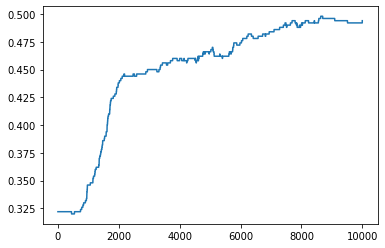

In [20]:
plt.plot(accuracy_array)

In [21]:
print(max(accuracy_array))
#all-MiniLM-L6-v2 = 0.466
#all-mpnet-base-v2 = 0.502
#sentence-transformers/bert-base-nli-mean-tokens = 0.4
#sentence-transformers/paraphrase-MiniLM-L6-v2 = 0.462

0.498


In [22]:
print(accuracy_array[-1])

0.494
